# Data Mining Project Part 1 
Aleksandra Hojszyk

In [34]:
import warnings
warnings.filterwarnings('ignore')
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

from scipy.stats import f_oneway, chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import ADASYN, SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            precision_recall_curve, roc_curve, accuracy_score
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, confusion_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.metrics import plot_roc_curve, auc
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

import dtreeviz.trees
from sklearn import tree

# Reading the data in Python 

I will load the data using ucimlrepo package in Python, as it is suggested here https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data. I will use the 'original' data, not the numeric version.

In [35]:
 # fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 

Transforming the data into dataframe

In [36]:
df = statlog_german_credit_data['data']['original'] #by selecting 'original' we can access the class atribute
df

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


Since in this way the data is less readable we will redefine column names and variables according to the description from the documentation. 



In [37]:
names = ['Existing Checking', 'Duration', 'Credit History', 'Purpose', 'Credit Amount', 
         'Savings', 'Employment Since', 'Installment Rate', 'Status Sex', 'Other Debtors', 
         'Residence Since', 'Property', 'Age', 'Other Installment Plans', 'Housing', 
         'Existing Credits', 'Job', 'People Liable', 'Telephone', 'Foreign Worker', 'Classification']
df.columns = names
df

,Existing Checking,Duration,Credit History,Purpose,Credit Amount,Savings,Employment Since,Installment Rate,Status Sex,Other Debtors,...,Property,Age,Other Installment Plans,Housing,Existing Credits,Job,People Liable,Telephone,Foreign Worker,Classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


For the purpose of data description I make a copy of the dataframe and trenslate the variables into more readable ones.

In [38]:
df_copy = df.copy()

Existing_Checking = {'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
df_copy.replace({"Existing Checking": Existing_Checking}, inplace=True)

Credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
df_copy.replace({"Credit History" : Credit_history}, inplace=True)  

Purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
df_copy.replace({ "Purpose": Purpose}, inplace=True)  

Savings={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
df_copy.replace({ "Savings": Savings}, inplace=True) 

Present_employment={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
df_copy.replace({ "Employment Since": Present_employment}, inplace=True)  

Status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
df_copy.replace({ "Status Sex": Status_and_sex}, inplace=True)   

Other_debtors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
df_copy.replace({ "Other Debtors": Other_debtors}, inplace=True) 

Property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
df_copy.replace({ "Property": Property}, inplace=True) 

Other_installment_plans={'A143':"none", 'A142':"store", 'A141':"bank"}
df_copy.replace({ "Other Installment Plans": Other_installment_plans}, inplace=True)  

Housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
df_copy.replace({ "Housing": Housing}, inplace=True) 

Job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unskilled - resident", 'A171':"unemployed/ unskilled  - non-resident"}
df_copy.replace({ "Job": Job}, inplace=True) 

Telephone={'A192':"yes", 'A191':"none"}
df_copy.replace({ "Telephone": Telephone}, inplace=True) 

foreign_worker={'A201':"yes", 'A202':"no"}
df_copy.replace({ "Foreign Worker": foreign_worker}, inplace=True)  

Residence_since = {4:">=7 years", 3:"4<= <7 years",  2:"1<= < 4 years", 1:"<1 years"}
df_copy.replace({ "Residence Since": Residence_since}, inplace=True)

Installment_rate =  {4:"<20", 3:"20<= ... <25",  2:"25<=...< 35", 1:"=>35"}
df_copy.replace({ "Installment Rate": Installment_rate}, inplace=True)

Existing_Credits = {1: "1", 2: "2 or 3", 3: "4 or 5", 4: "6 or more"}
df_copy.replace({ "Existing Credits": Existing_Credits}, inplace=True)

People_Liable = {1: "3 or more", 2: "0 to 2"}
df_copy.replace({ "People Liable": People_Liable}, inplace=True)

df_copy.replace({"Classification" : {1: "Good", 2: "Bad"}}, inplace=True)

df_copy

,Existing Checking,Duration,Credit History,Purpose,Credit Amount,Savings,Employment Since,Installment Rate,Status Sex,Other Debtors,...,Property,Age,Other Installment Plans,Housing,Existing Credits,Job,People Liable,Telephone,Foreign Worker,Classification
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,<20,male:single,none,...,real estate,67,none,own,2 or 3,skilled employee / official,3 or more,yes,yes,Good
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,25<=...< 35,female:divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,3 or more,none,yes,Bad
2,no checking account,12,critical account,education,2096,<100 DM,4<= <7 years,25<=...< 35,male:single,none,...,real estate,49,none,own,1,unskilled - resident,0 to 2,none,yes,Good
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,25<=...< 35,male:single,guarantor,...,savings agreement/life insurance,45,none,for free,1,skilled employee / official,0 to 2,none,yes,Good
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,20<= ... <25,male:single,none,...,unknown / no property,53,none,for free,2 or 3,skilled employee / official,0 to 2,none,yes,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking account,12,existing credits paid back duly till now,furniture/equipment,1736,<100 DM,4<= <7 years,20<= ... <25,female:divorced/separated/married,none,...,real estate,31,none,own,1,unskilled - resident,3 or more,none,yes,Good
996,<0 DM,30,existing credits paid back duly till now,car (used),3857,<100 DM,1<= < 4 years,<20,male:divorced/separated,none,...,savings agreement/life insurance,40,none,own,1,management/ highly qualified employee,3 or more,yes,yes,Good
997,no checking account,12,existing credits paid back duly till now,radio/television,804,<100 DM,>=7 years,<20,male:single,none,...,car or other,38,none,own,1,skilled employee / official,3 or more,none,yes,Good
998,<0 DM,45,existing credits paid back duly till now,radio/television,1845,<100 DM,1<= < 4 years,<20,male:single,none,...,unknown / no property,23,none,for free,1,skilled employee / official,3 or more,yes,yes,Bad


# Checking basic properties of the dataset

In this section I will check:

* what is the size of the dataset (number of rows and columns)
* missing values,
* type of atribute (numerical or categorical)

In [39]:
df.shape

(1000, 21)

Here we can see that the dataset contains 21 attributes (20 features\predictors and 1 traget\ response variables) and consists of 1000 records.

In [40]:
df.isna().sum()

Existing Checking          0
Duration                   0
Credit History             0
Purpose                    0
Credit Amount              0
Savings                    0
Employment Since           0
Installment Rate           0
Status Sex                 0
Other Debtors              0
Residence Since            0
Property                   0
Age                        0
Other Installment Plans    0
Housing                    0
Existing Credits           0
Job                        0
People Liable              0
Telephone                  0
Foreign Worker             0
Classification             0
dtype: int64

We can also check for duplicated values. There are none.

In [41]:
df.duplicated().sum()

0

Here we have verified that our set does not contain any missing values. Let's now look at the datatypes.

# Assigning correct data types

In [42]:
d_types_table = pd.DataFrame(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Existing Checking        1000 non-null   object
 1   Duration                 1000 non-null   int64 
 2   Credit History           1000 non-null   object
 3   Purpose                  1000 non-null   object
 4   Credit Amount            1000 non-null   int64 
 5   Savings                  1000 non-null   object
 6   Employment Since         1000 non-null   object
 7   Installment Rate         1000 non-null   int64 
 8   Status Sex               1000 non-null   object
 9   Other Debtors            1000 non-null   object
 10  Residence Since          1000 non-null   int64 
 11  Property                 1000 non-null   object
 12  Age                      1000 non-null   int64 
 13  Other Installment Plans  1000 non-null   object
 14  Housing                  1000 non-null   

Here we can see that the only datatypes used in this dataset are object (for categorical variables)  and int64 for numerical variables. We can switch the object datatype to dtype='category' as it reflects the properties of 'factor' in R. I will also switch 'Classification' attribute to category type.

In [43]:
datatypes = df.columns.to_series().groupby(df.dtypes).groups
datatypes_dict = {k.name: v for k, v in datatypes.items()}

In [44]:
for column in list(datatypes_dict['object']):
    df[column] = df[column].astype("category")

df['Classification'] = df['Classification'].astype("category")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Existing Checking        1000 non-null   category
 1   Duration                 1000 non-null   int64   
 2   Credit History           1000 non-null   category
 3   Purpose                  1000 non-null   category
 4   Credit Amount            1000 non-null   int64   
 5   Savings                  1000 non-null   category
 6   Employment Since         1000 non-null   category
 7   Installment Rate         1000 non-null   int64   
 8   Status Sex               1000 non-null   category
 9   Other Debtors            1000 non-null   category
 10  Residence Since          1000 non-null   int64   
 11  Property                 1000 non-null   category
 12  Age                      1000 non-null   int64   
 13  Other Installment Plans  1000 non-null   category
 14  Housing  

Here we can also check for number of unique values for each feature and check with data description if they are correct.

In [46]:
df.nunique()

Existing Checking            4
Duration                    33
Credit History               5
Purpose                     10
Credit Amount              921
Savings                      5
Employment Since             5
Installment Rate             4
Status Sex                   4
Other Debtors                3
Residence Since              4
Property                     4
Age                         53
Other Installment Plans      3
Housing                      3
Existing Credits             4
Job                          4
People Liable                2
Telephone                    2
Foreign Worker               2
Classification               2
dtype: int64

In [47]:
for i, col in enumerate(df.select_dtypes(include =['category']).columns):
  print(i+1,col, "  : ",df[col].unique())

1 Existing Checking   :  ['A11', 'A12', 'A14', 'A13']
Categories (4, object): ['A11', 'A12', 'A13', 'A14']
2 Credit History   :  ['A34', 'A32', 'A33', 'A30', 'A31']
Categories (5, object): ['A30', 'A31', 'A32', 'A33', 'A34']
3 Purpose   :  ['A43', 'A46', 'A42', 'A40', 'A41', 'A49', 'A44', 'A45', 'A410', 'A48']
Categories (10, object): ['A40', 'A41', 'A410', 'A42', ..., 'A45', 'A46', 'A48', 'A49']
4 Savings   :  ['A65', 'A61', 'A63', 'A64', 'A62']
Categories (5, object): ['A61', 'A62', 'A63', 'A64', 'A65']
5 Employment Since   :  ['A75', 'A73', 'A74', 'A71', 'A72']
Categories (5, object): ['A71', 'A72', 'A73', 'A74', 'A75']
6 Status Sex   :  ['A93', 'A92', 'A91', 'A94']
Categories (4, object): ['A91', 'A92', 'A93', 'A94']
7 Other Debtors   :  ['A101', 'A103', 'A102']
Categories (3, object): ['A101', 'A102', 'A103']
8 Property   :  ['A121', 'A122', 'A124', 'A123']
Categories (4, object): ['A121', 'A122', 'A123', 'A124']
9 Other Installment Plans   :  ['A143', 'A141', 'A142']
Categories (

Looking at the data above for categorical data, we can observe that the value 'A95' does not appear in the dataset (which means single female), as well as 'A47' which means vacation.


# Data prepocessing

## Grouping rare categories

Since there are very many categories for some of the features I have decided to first look at the distribution of each category of a feature and then group some of the rare ones, which come from similar groups.

In [48]:
numerical_col = ['Age', 'Duration', 'Credit Amount']

column_names = df_copy.columns.tolist()
for col in numerical_col:
    column_names.remove(col)

column_names_cat={}
for name in column_names:
    column_names_cat[name]=df_copy[name].nunique()


# clustering the attributes by number on unique values
marginal_report_cluster={}
for itr in range(0,np.asarray(list(column_names_cat.values())).max()+1):
    if [k for k,v in column_names_cat.items() if v == itr]:
        marginal_report_cluster[itr]=[k for k,v in column_names_cat.items() if v == itr]

#report lists with percentages for each variable
report_list = []
for key in marginal_report_cluster.keys():
    marginal_percentage_report=[]
    for name in sorted(marginal_report_cluster[key]):
        data=pd.crosstab(df_copy[name],columns=["Percentage"]).apply(lambda r: (round((r/r.sum())*100,2)), axis=0).reset_index()
        data.columns=[name,"Percentage"]
        data=data.transpose().reset_index()
        [marginal_percentage_report.append(x) for x in data.values.tolist()]
        options=[]
    marginal_percentage_report=pd.DataFrame(marginal_percentage_report)
    [options.append("Category "+str(itr)) for itr in range(1,len(marginal_percentage_report.columns))]
    marginal_percentage_report.columns=["Attribute"]+options
    report_list.append(marginal_percentage_report)

In [49]:
report_list[0]

,Attribute,Category 1,Category 2
0,Classification,Bad,Good
1,Percentage,30.0,70.0
2,Foreign Worker,no,yes
3,Percentage,3.7,96.3
4,People Liable,0 to 2,3 or more
5,Percentage,15.5,84.5
6,Telephone,none,yes
7,Percentage,59.6,40.4


For the 'Classification' target variable 70% of observation belong to the negative class while only the  30% to the positive one. This is not an high imbalance but should be considered.

In [50]:
report_list[1]

,Attribute,Category 1,Category 2,Category 3
0,Housing,for free,own,rent
1,Percentage,10.8,71.3,17.9
2,Other Debtors,co-applicant,guarantor,none
3,Percentage,4.1,5.2,90.7
4,Other Installment Plans,bank,none,store
5,Percentage,13.9,81.4,4.7


In [51]:
report_list[2]

,Attribute,Category 1,Category 2,Category 3,Category 4
0,Existing Checking,0 <= <200 DM,<0 DM,>= 200 DM,no checking account
1,Percentage,26.9,27.4,6.3,39.4
2,Existing Credits,1,2 or 3,4 or 5,6 or more
3,Percentage,63.3,33.3,2.8,0.6
4,Installment Rate,20<= ... <25,25<=...< 35,<20,=>35
5,Percentage,15.7,23.1,47.6,13.6
6,Job,management/ highly qualified employee,skilled employee / official,unemployed/ unskilled - non-resident,unskilled - resident
7,Percentage,14.8,63.0,2.2,20.0
8,Property,car or other,real estate,savings agreement/life insurance,unknown / no property
9,Percentage,33.2,28.2,23.2,15.4


Here we can see that proportion of '4 or 5' and '6 or more' for the status of existing credits are both quite low, so I have decided to merge these two categories.
Simillar for Job feature the percentage for 'unemployed/ unskilled - non-resident' and 'unskilled - resident' are quite low and the categories are similar, there I will combine these in the next step. Lastly the 'Status Sex' column is quite confusing, i have decided it will be best to transform it to just 'Sex' column with either male or female.

In [52]:
report_list[3]

,Attribute,Category 1,Category 2,Category 3,Category 4,Category 5
0,Credit History,all credits at this bank paid back duly,critical account,delay in paying off,existing credits paid back duly till now,no credits taken
1,Percentage,4.9,29.3,8.8,53.0,4.0
2,Employment Since,1<= < 4 years,4<= <7 years,<1 years,>=7 years,unemployed
3,Percentage,33.9,17.4,17.2,25.3,6.2
4,Savings,100 <= <500 DM,500 <= < 1000 DM,<100 DM,>= 1000 DM,no savings account
5,Percentage,10.3,6.3,60.3,4.8,18.3


In [53]:
report_list[4]

,Attribute,Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
0,Purpose,business,car (new),car (used),domestic appliances,education,furniture/equipment,others,radio/television,repairs,retraining
1,Percentage,9.7,23.4,10.3,1.2,5.0,18.1,1.2,28.0,2.2,0.9


## Merging chosen categories

In this part I will merge the chosen categories for 'Existing Credits' , 'Job', and 'Status Sex' columns. 

In [54]:
df_copy2 = df.copy()

Existing_Checking = {'A14':"no checking account",'A11':"<0 DM", 'A12': "0 <= <200 DM",'A13':">= 200 DM "}
df_copy2.replace({"Existing Checking": Existing_Checking}, inplace=True)

Credit_history={"A34":"critical account","A33":"delay in paying off","A32":"existing credits paid back duly till now","A31":"all credits at this bank paid back duly","A30":"no credits taken"}
df_copy2.replace({"Credit History" : Credit_history}, inplace=True)  

Purpose={"A40" : "car (new)", "A41" : "car (used)", "A42" : "furniture/equipment", "A43" :"radio/television" , "A44" : "domestic appliances", "A45" : "repairs", "A46" : "education", 'A47' : 'vacation','A48' : 'retraining','A49' : 'business','A410' : 'others'}
df_copy2.replace({ "Purpose": Purpose}, inplace=True)  

Savings={"A65" : "no savings account","A61" :"<100 DM","A62" : "100 <= <500 DM","A63" :"500 <= < 1000 DM", "A64" :">= 1000 DM"}
df_copy2.replace({ "Savings": Savings}, inplace=True) 

Present_employment={'A75':">=7 years", 'A74':"4<= <7 years",  'A73':"1<= < 4 years", 'A72':"<1 years",'A71':"unemployed"}
df_copy2.replace({ "Employment Since": Present_employment}, inplace=True)  

# combined to sex feature
Status_and_sex={ 'A95':"female",'A94':"male",'A93':"male", 'A92':"female", 'A91':"male"}
df_copy2.replace({ "Status Sex": Status_and_sex}, inplace=True)   

Other_debtors={'A101':"none", 'A102':"co-applicant", 'A103':"guarantor"}
df_copy2.replace({ "Other Debtors": Other_debtors}, inplace=True) 

Property={'A121':"real estate", 'A122':"savings agreement/life insurance", 'A123':"car or other", 'A124':"unknown / no property"}
df_copy2.replace({ "Property": Property}, inplace=True) 

Other_installment_plans={'A143':"none", 'A142':"store", 'A141':"bank"}
df_copy2.replace({ "Other Installment Plans": Other_installment_plans}, inplace=True)  

Housing={'A153':"for free", 'A152':"own", 'A151':"rent"}
df_copy2.replace({ "Housing": Housing}, inplace=True) 

# combining categories for Job 
Job={'A174':"management/ highly qualified employee", 'A173':"skilled employee / official", 'A172':"unemployed/ unskilled", 'A171':"unemployed/ unskilled"} 
df_copy2.replace({ "Job": Job}, inplace=True) 

Telephone={'A192':"yes", 'A191':"none"}
df_copy2.replace({ "Telephone": Telephone}, inplace=True) 

foreign_worker={'A201':"yes", 'A202':"no"}
df_copy2.replace({ "Foreign Worker": foreign_worker}, inplace=True)  

Residence_since = {4:">=7 years", 3:"4<= <7 years",  2:"1<= < 4 years", 1:"<1 years"}
df_copy2.replace({ "Residence Since": Residence_since}, inplace=True)

Installment_rate =  {4:"<20", 3:"20<= ... <25",  2:"25<=...< 35", 1:"=>35"}
df_copy2.replace({ "Installment Rate": Installment_rate}, inplace=True)

# combined to 4 or more
Existing_Credits = {1: "1", 2: "2 or 3", 3: "4 or more", 4: "4 or more"}
df_copy2.replace({ "Existing Credits": Existing_Credits}, inplace=True)

People_Liable = {1: "3 or more", 2: "0 to 2"}
df_copy2.replace({ "People Liable": People_Liable}, inplace=True)

df_copy2.replace({"Classification" : {1: "Good", 2: "Bad"}}, inplace=True)

df_copy2

,Existing Checking,Duration,Credit History,Purpose,Credit Amount,Savings,Employment Since,Installment Rate,Status Sex,Other Debtors,...,Property,Age,Other Installment Plans,Housing,Existing Credits,Job,People Liable,Telephone,Foreign Worker,Classification
0,<0 DM,6,critical account,radio/television,1169,no savings account,>=7 years,<20,male,none,...,real estate,67,none,own,2 or 3,skilled employee / official,3 or more,yes,yes,Good
1,0 <= <200 DM,48,existing credits paid back duly till now,radio/television,5951,<100 DM,1<= < 4 years,25<=...< 35,female,none,...,real estate,22,none,own,1,skilled employee / official,3 or more,none,yes,Bad
2,no checking account,12,critical account,education,2096,<100 DM,4<= <7 years,25<=...< 35,male,none,...,real estate,49,none,own,1,unemployed/ unskilled,0 to 2,none,yes,Good
3,<0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,<100 DM,4<= <7 years,25<=...< 35,male,guarantor,...,savings agreement/life insurance,45,none,for free,1,skilled employee / official,0 to 2,none,yes,Good
4,<0 DM,24,delay in paying off,car (new),4870,<100 DM,1<= < 4 years,20<= ... <25,male,none,...,unknown / no property,53,none,for free,2 or 3,skilled employee / official,0 to 2,none,yes,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking account,12,existing credits paid back duly till now,furniture/equipment,1736,<100 DM,4<= <7 years,20<= ... <25,female,none,...,real estate,31,none,own,1,unemployed/ unskilled,3 or more,none,yes,Good
996,<0 DM,30,existing credits paid back duly till now,car (used),3857,<100 DM,1<= < 4 years,<20,male,none,...,savings agreement/life insurance,40,none,own,1,management/ highly qualified employee,3 or more,yes,yes,Good
997,no checking account,12,existing credits paid back duly till now,radio/television,804,<100 DM,>=7 years,<20,male,none,...,car or other,38,none,own,1,skilled employee / official,3 or more,none,yes,Good
998,<0 DM,45,existing credits paid back duly till now,radio/television,1845,<100 DM,1<= < 4 years,<20,male,none,...,unknown / no property,23,none,for free,1,skilled employee / official,3 or more,yes,yes,Bad


In [55]:
# Merging for original df
df_comb = df.copy()

# combined to sex feature
Sex={ 'A95':'A92','A94':'A91','A93':'A91', 'A92':'A92', 'A91':'A91'}
df_comb.replace({ "Status Sex": Sex}, inplace=True) 

# combining categories for Job 
Job={'A174':'A174', 'A173':'A173', 'A172':'A172', 'A171':'A172'} 
df_comb.replace({ "Job": Job}, inplace=True) 

# combined to 4 or more
Existing_Credits = {1: 1, 2: 2, 3: 3, 4: 3}
df_comb.replace({ "Existing Credits": Existing_Credits}, inplace=True)


# Univariate Analysis

In [77]:
# Define custom bright coral and turquoise color palette
coral_turquoise_palette = ["#FF6347", "#40E0D0", "#FF4500", "#20B2AA", "#FF7F50"]

# Set the custom palette in Seaborn
sns.set_palette(coral_turquoise_palette)

# Optionally, you can also customize other Seaborn styles
sns.set_style("whitegrid", {
    'axes.facecolor': '#F5F5F5',
    'grid.color': '#E0E0E0',
    'axes.edgecolor': '#E0E0E0'
})

# If you want to customize Matplotlib directly, you can use rcParams
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=coral_turquoise_palette)
plt.rcParams['axes.facecolor'] = '#F5F5F5'
plt.rcParams['grid.color'] = '#E0E0E0'
plt.rcParams['axes.edgecolor'] = '#E0E0E0'

## Continuous Variables

Let us first look at some basic statistics 

In [78]:
df[numerical_col].describe()

,Age,Duration,Credit Amount
count,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000
std,11.375469,12.058814,2822.736876
min,19.000000,4.000000,250.000000
25%,27.000000,12.000000,1365.500000
50%,33.000000,18.000000,2319.500000
75%,42.000000,24.000000,3972.250000
max,75.000000,72.000000,18424.000000


Looking at the table above, we see that the mean age of a loaner is about 35, while the youngest one is 19 and oldest is 75. These statistics also show that we do not have any anomalies in the data (like people age -20). The 3rd quartile is 42, which suggest that mostly young people, below age 42 take credits. 

Statistics for duration show that the mean duration is approximately 21 months and the standard deviation is 12 months. This makes sense since most bank give credits for durations that round up to years (1, 2 or 3 years) and rarely for example for 14 months. Looking at the table we can also notice that the minimun duration is 4 months (quarter), and maximum is 72 months which is equal to 6 years. 

The column with credit amount shows that the lowest credit was taken for 250 DM and the highest one for 18424 DM. The standard deviation is quite large for this column, which we may assume comes from the fact that the credits were taken for different purposes (some very expensive ones and some affordable ones). The mean credit amount is 3271 DM. 

In [79]:
def histogram_boxplot(data, feature):

    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  
        sharex=True, 
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=(12, 7))  
    
    sns.boxplot(data=data, x=feature, ax=ax_box2)
    sns.histplot(data=data, x=feature, kde=None, ax=ax_hist2, bins = 12) 


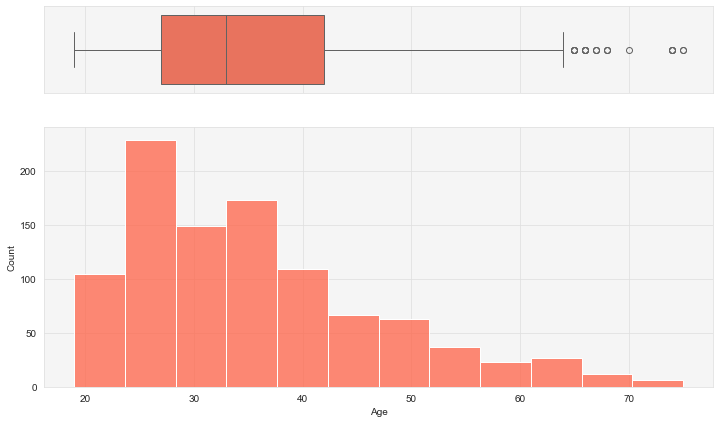

In [80]:
histogram_boxplot(df, "Age")

Here we can see that the histogram is right / positive skewd. The most applicants for credit are between age 20 and 30. Lookingv at the histogram we can see some outliers (according to the definition based on boxplot interpretation), we can say that very few people decide to take a loan around the age of 70. 

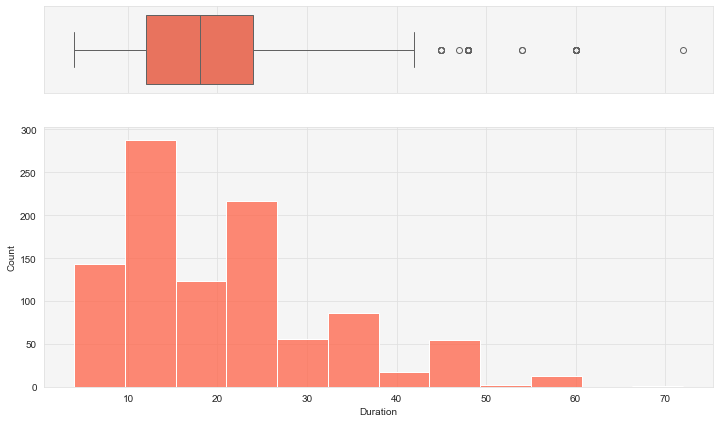

In [81]:
histogram_boxplot(df, "Duration")

Here the histogram for the duration in months is more sparsely spread. We can assume that most common duration is 12 or 24 months, while the credits taken for duration longer than 4 years (48 months) are rare.

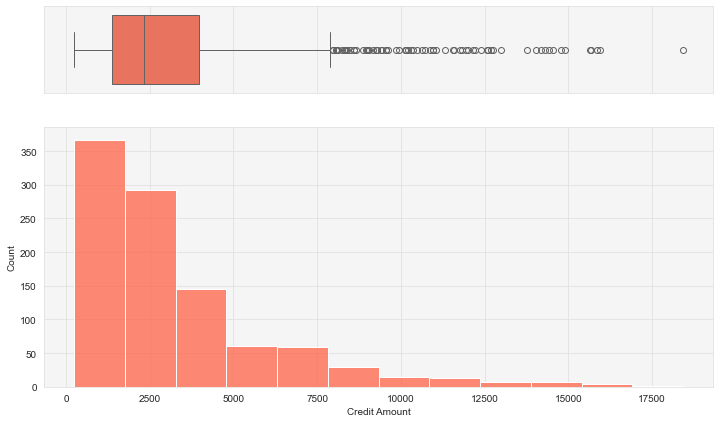

In [82]:
histogram_boxplot(df, "Credit Amount")

The histogram for Credit Amount is definitly right skewed, which means that most people take credits for low amounts. As mentioned in the section with basic statistics, we can see that the data for 'Credit Amount' has high variability.

## Categorical Variables

In [83]:
#dividing the column names into chunks for plotting
chunks = [column_names[x:x+3] for x in [0,3,6,9,12,15]]

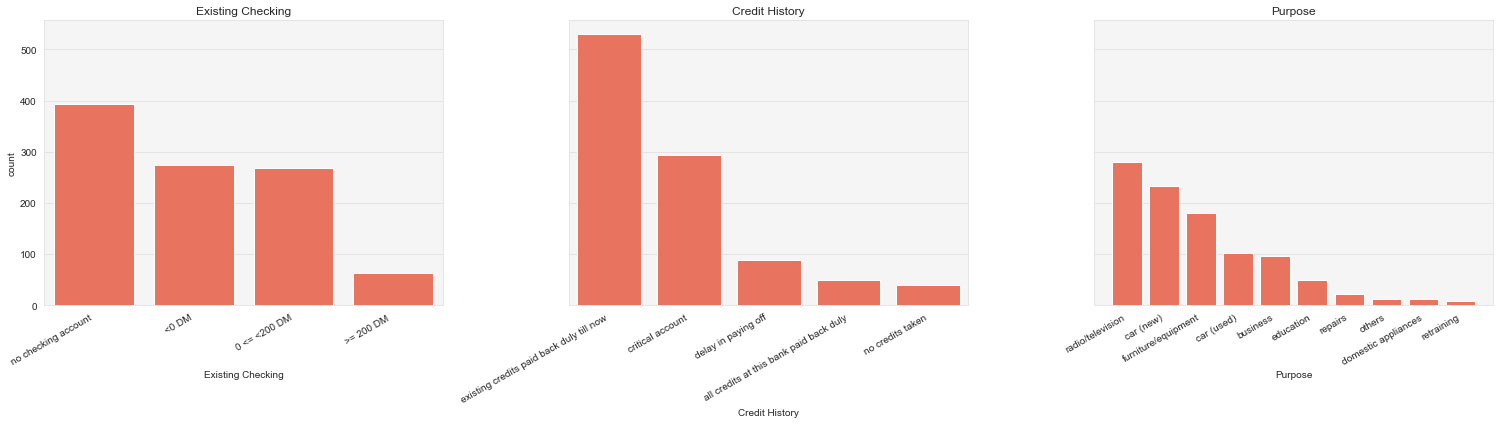

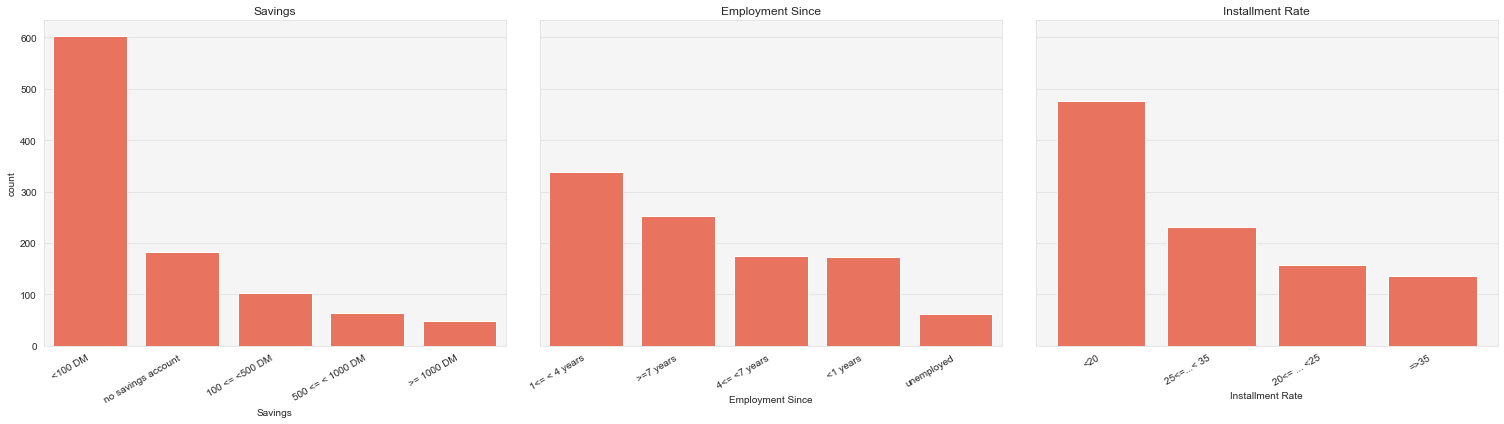

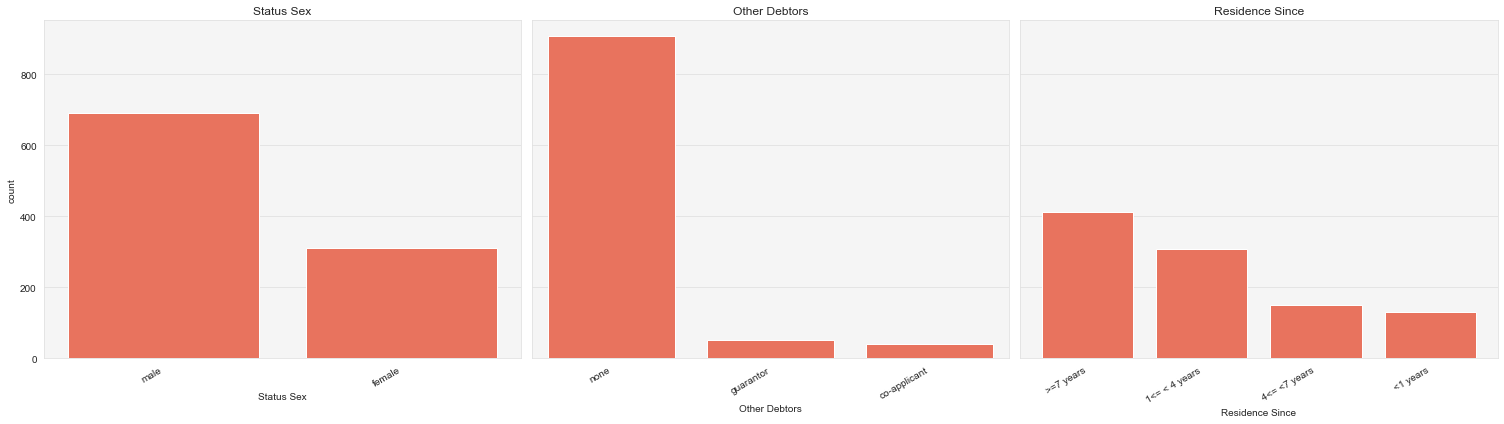

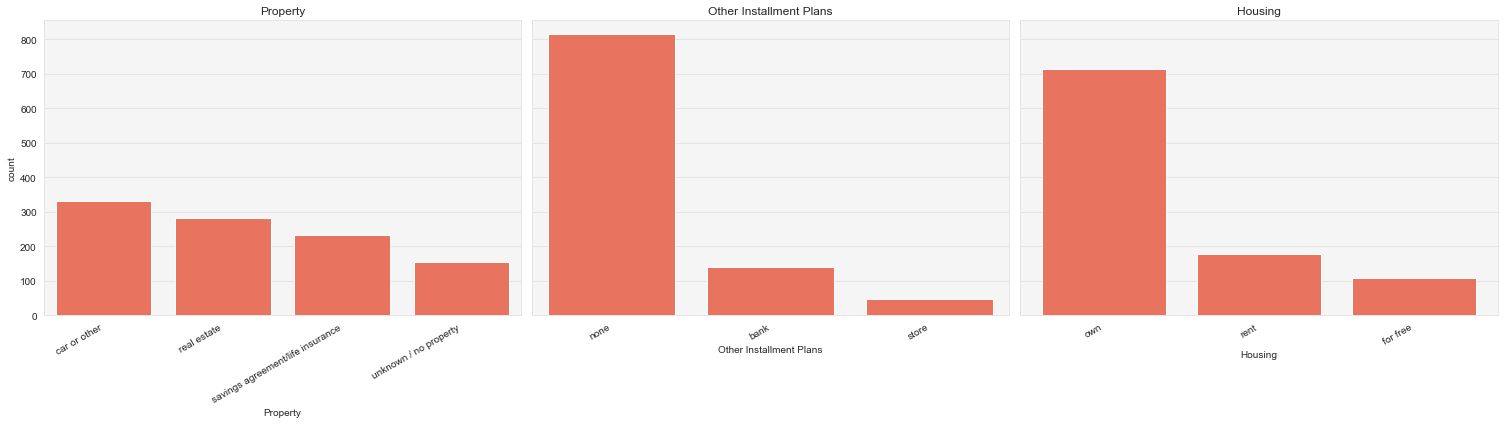

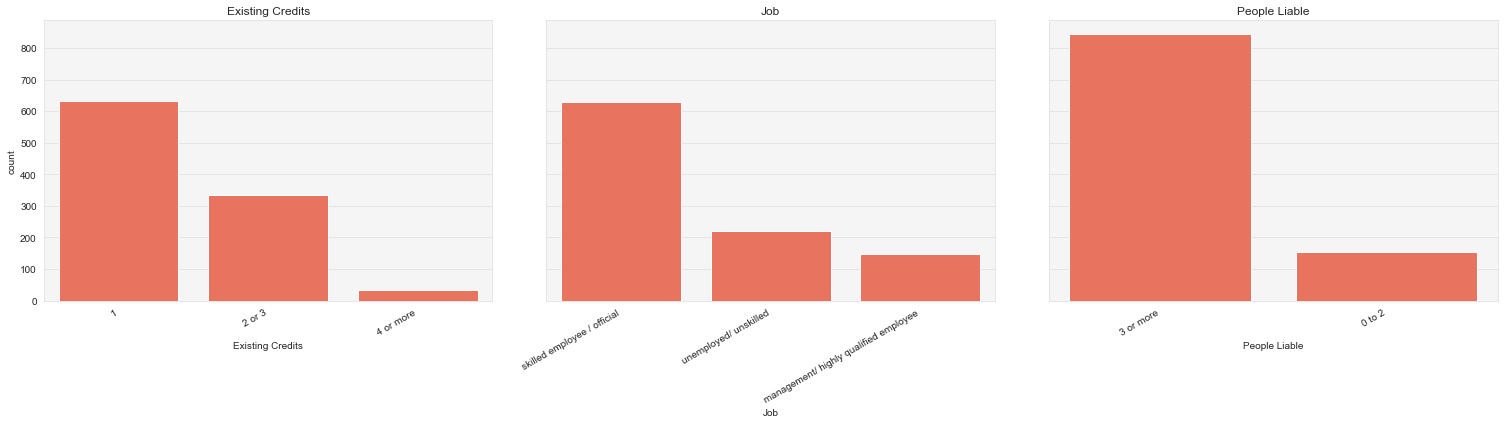

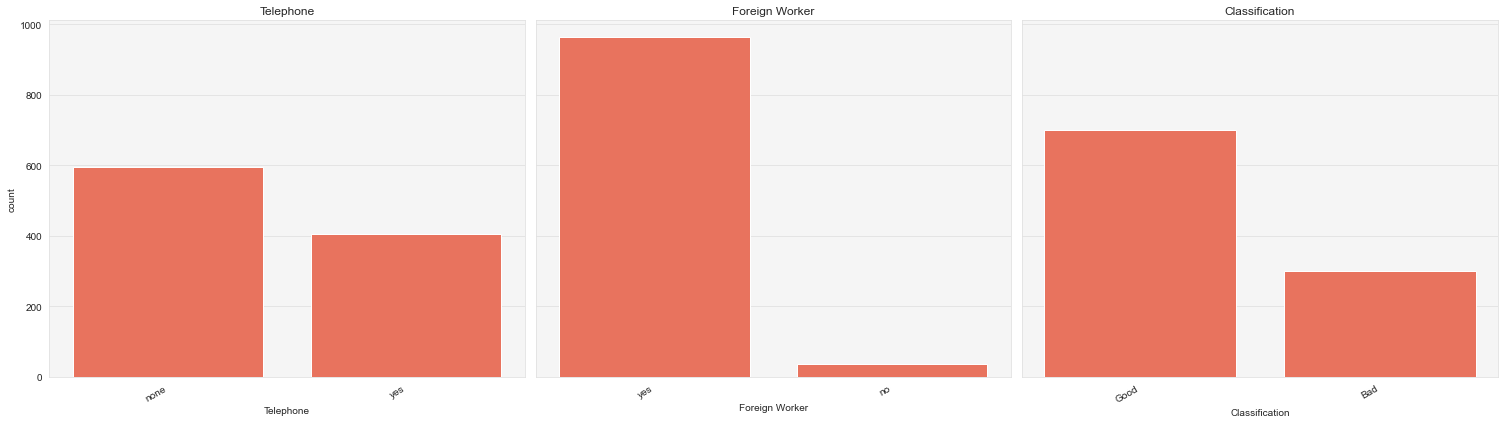

In [84]:
def plot_3_barplots(chunk, data):

    fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)

    sns.countplot(ax=axes[0], x=chunk[0] , data = data, order = data[chunk[0]].value_counts().index)
    axes[0].set_title(chunk[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha="right")

    sns.countplot(ax=axes[1], x=chunk[1] , data = data, order = data[chunk[1]].value_counts().index)
    axes[1].set_title(chunk[1])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha="right")

    sns.countplot(ax=axes[2], x=chunk[2] , data = data, order = data[chunk[2]].value_counts().index)
    axes[2].set_title(chunk[2])
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30, ha="right")

    
    plt.tight_layout()
    plt.plot()

for i in chunks:
    plot_3_barplots(i, df_copy2)

# Bivariate Analysis

## Summary statistics within groups

In [85]:
good = df_copy2[df_copy2['Classification'] == 'Good']
bad = df_copy2[df_copy2['Classification'] == 'Bad']

In [86]:
summary_good_bad = pd.concat([bad.describe(),good.describe()], axis = 1)
summary_good_bad.columns = ["Duration_bad", "Credit Amount_bad", "Age_bad", "Duration_good", "Credit Amount_good", "Age_good"]
summary_good_bad = pd.concat([summary_good_bad["Duration_bad"], summary_good_bad["Duration_good"] , summary_good_bad["Credit Amount_bad"] , summary_good_bad["Credit Amount_good"] , summary_good_bad["Age_bad"] , summary_good_bad["Age_good"] ] , axis = 1)
summary_good_bad.round(2)

,Duration_bad,Duration_good,Credit Amount_bad,Credit Amount_good,Age_bad,Age_good
count,300.00,700.00,300.00,700.00,300.00,700.00
mean,24.86,19.21,3938.13,2985.46,33.96,36.22
std,13.28,11.08,3535.82,2401.47,11.22,11.38
min,6.00,4.00,433.00,250.00,19.00,19.00
25%,12.00,12.00,1352.50,1375.50,25.00,27.00
50%,24.00,18.00,2574.50,2244.00,31.00,34.00
75%,36.00,24.00,5141.50,3634.75,40.00,42.25
max,72.00,60.00,18424.00,15857.00,74.00,75.00


Here is the comparison for "Bad" and "Good" group for continuos variables. 

* Duration: The mean duration is lower for "Good" customers. All other statistics are lower as well, which suggests that in general "Good" customers take credits for shorter duration.

* Credit Amount: Here the mean and minimum are noticably lower for "Good" customers as well as standard deviation. However Q1 and Q2 are similar. This suggests that "Bad" customers do not take credit for very low amounts  and generally take credit for larger sums. 

* Age: In general "Bad" customers are a bit younger. Allthough the range of age for "good" and "bad" applicants is very similar. It seems Age is not a very good predictor compared to duration and credit amount.

## Numerical data

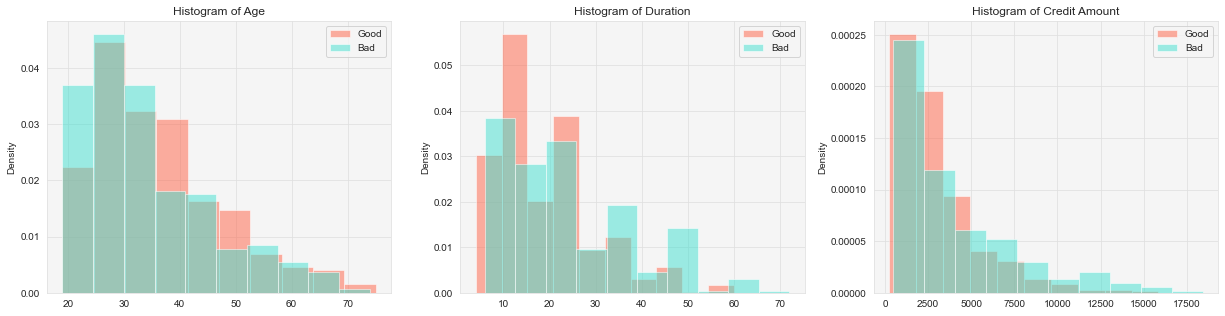

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

ax[0].hist(good["Age"], density = True, label = "Good", alpha=0.5)
ax[0].hist(bad["Age"], density = True, label = "Bad", alpha=0.5)
ax[0].legend()
ax[0].set_title("Histogram of Age")
ax[0].set_ylabel("Density")

ax[1].hist(good["Duration"], density = True, label = "Good", alpha=0.5)
ax[1].hist(bad["Duration"], density = True, label = "Bad", alpha=0.5)
ax[1].legend()
ax[1].set_title("Histogram of Duration")
ax[1].set_ylabel("Density")


ax[2].hist(good["Credit Amount"], density = True, label = "Good", alpha=0.5)
ax[2].hist(bad["Credit Amount"], density = True, label = "Bad", alpha=0.5)
ax[2].legend()
ax[2].set_title("Histogram of Credit Amount")
ax[2].set_ylabel("Density")

plt.show()

From the above set of histograms in general we can see similar shapes for both "Good" and "Bad" and also similar ranges.

* Age: Histogram for "Bad" group is more skewed compared to the other group. For "Good" group most people are between ages of 25 to 40, while for the "Bad" group most people are a bit younger, between 20 to 35. 

* Duration: For "Bad" group the duration is a bit more evenly distributed, where for the "Good" group we can see a large peak around 12 months and around 24 months. 

* Credit Amount: Here we can notice that the majority of "Good" group takes credit up to 5000 DM, while the "Bad" group takes credit for higher amounts more often.

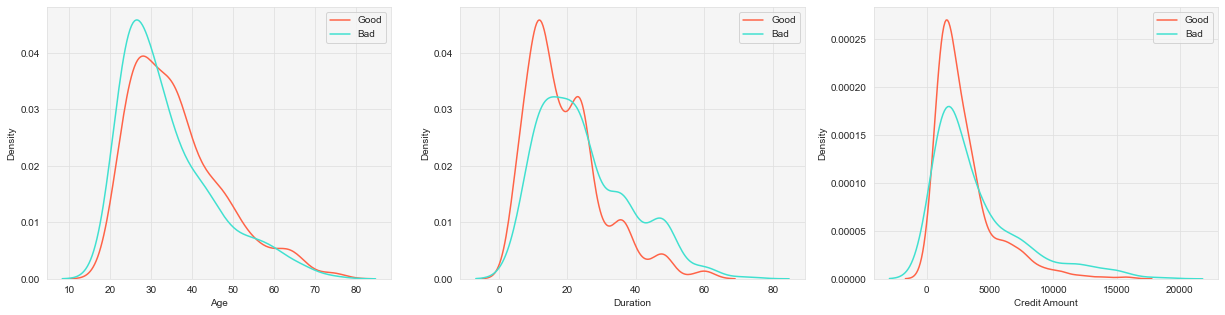

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5))

sns.kdeplot(ax=axes[0], data=good, x = "Age", label = "Good")
sns.kdeplot(ax=axes[0], data=bad, x = "Age", label = "Bad")
axes[0].legend()

sns.kdeplot(ax=axes[1], data=good, x = "Duration", label = "Good")
sns.kdeplot(ax=axes[1], data=bad, x = "Duration", label = "Bad")
axes[1].legend()

sns.kdeplot(ax=axes[2], data=good, x = "Credit Amount", label = "Good")
sns.kdeplot(ax=axes[2], data=bad, x = "Credit Amount", label = "Bad")
axes[2].legend()

plt.show()


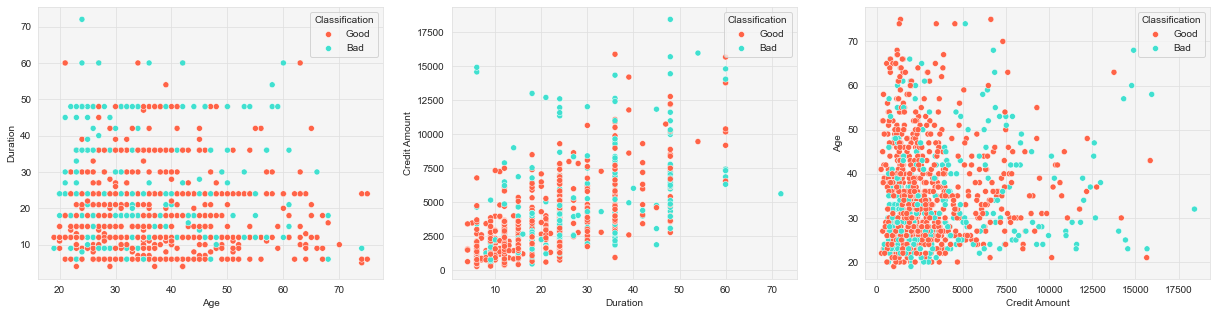

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5))
sns.scatterplot(ax=axes[0], data=df_copy2, x = "Age", y = "Duration", hue = "Classification")
sns.scatterplot(ax=axes[1], data=df_copy2, x = "Duration", y = "Credit Amount", hue = "Classification")
sns.scatterplot(ax=axes[2], data=df_copy2, x = "Credit Amount", y = "Age", hue = "Classification")
plt.show()

On the plot above we have a scatter plot for all pairs of continuous features with different colors for "Good" and "Bad" label. We can observe some linear realtionship between credit amount and duartion variables, which will be further examined using correlation matrix. Remaining two plots do not show a noticable positive or negative relationship. 

In [90]:
num_target = numerical_col
#num_target.append("Classification")
#num_target

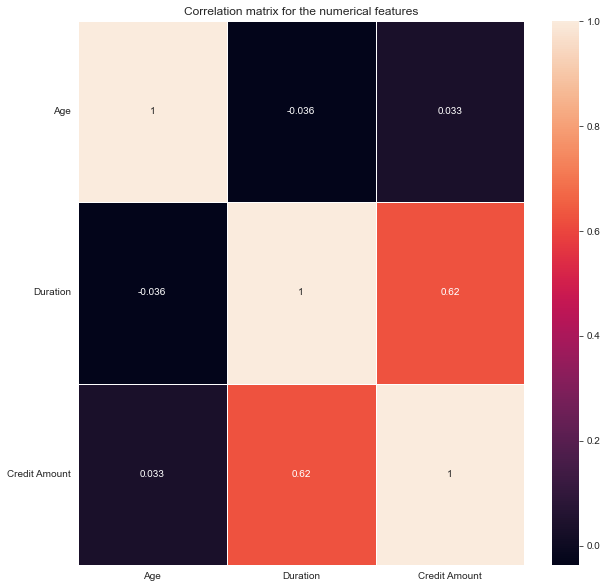

In [92]:
corr = df[numerical_col].corr()

fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr, annot=True, linewidth=0.5, xticklabels=numerical_col)
ax.set_yticklabels(labels=numerical_col, rotation=0)
ax.set_title("Correlation matrix for the numerical features")
plt.show()

After computing the correlation matrix we can see that there in fact is some linear positive relationship for 'Duration' and 'Credit Amount' (0.62), however it is not very strong (0.62 < 0.70). Therefore I have decided to keep all 3 continuous variables. The correlation for other two pairs is very small. 

Now I will examine the boxplots above to hopefully find some features with good discriminative ablilities. 


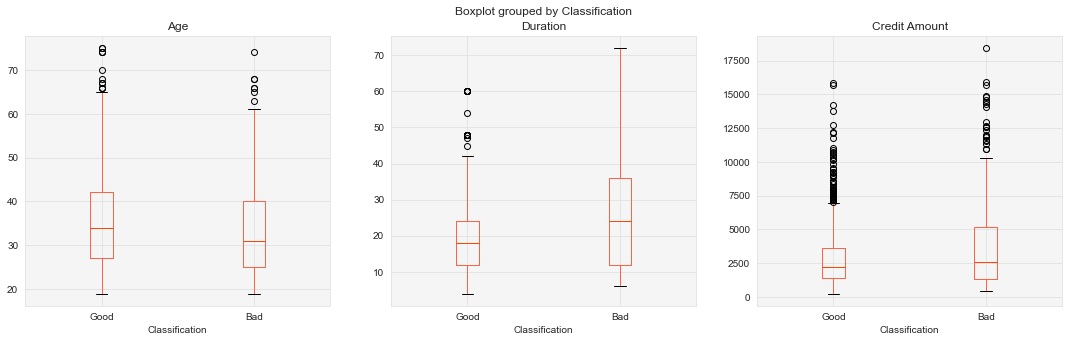

In [93]:
fig, PlotCanvas= plt.subplots(nrows=1, ncols=len(numerical_col), figsize=(18,5))
for PredictorCol , i in zip(numerical_col, range(len(numerical_col))):
    df_copy2.boxplot(column=PredictorCol, by='Classification', figsize=(5,5),  ax=PlotCanvas[i])

* For 'Age' vs 'Classification' boxplots we do not see many differences, the boxes are on similar levels and also the median is very similar. This means that people whose loan was rejected and whose loan was approved were similar in this category. Out of these 3 features this one displays the poorest discriminative ablility.

* For 'Duration' vs 'Classification' we see some more differences. For applicants classified as 'Good' the IQR is smaller compared to the one for 'Bad' applicants. However they still overlap, which means we can not distinguish 'Bad' and 'Good' bank custumers based on this feature only.

* For 'Credit Amount' vs 'Classification' there are noticeably more outliers in both groups. Here the IQR of "Good" group is also smaller compared to IQR of the "Bad" group. 

Since for all 3 pairs of plots the boxes overlap, there are no features with very good discriminative ablilities.

## Categorical Data

Below are the mosaic plots for categorical data, the red color corresponds to "Good" customers, green to "Bad". 

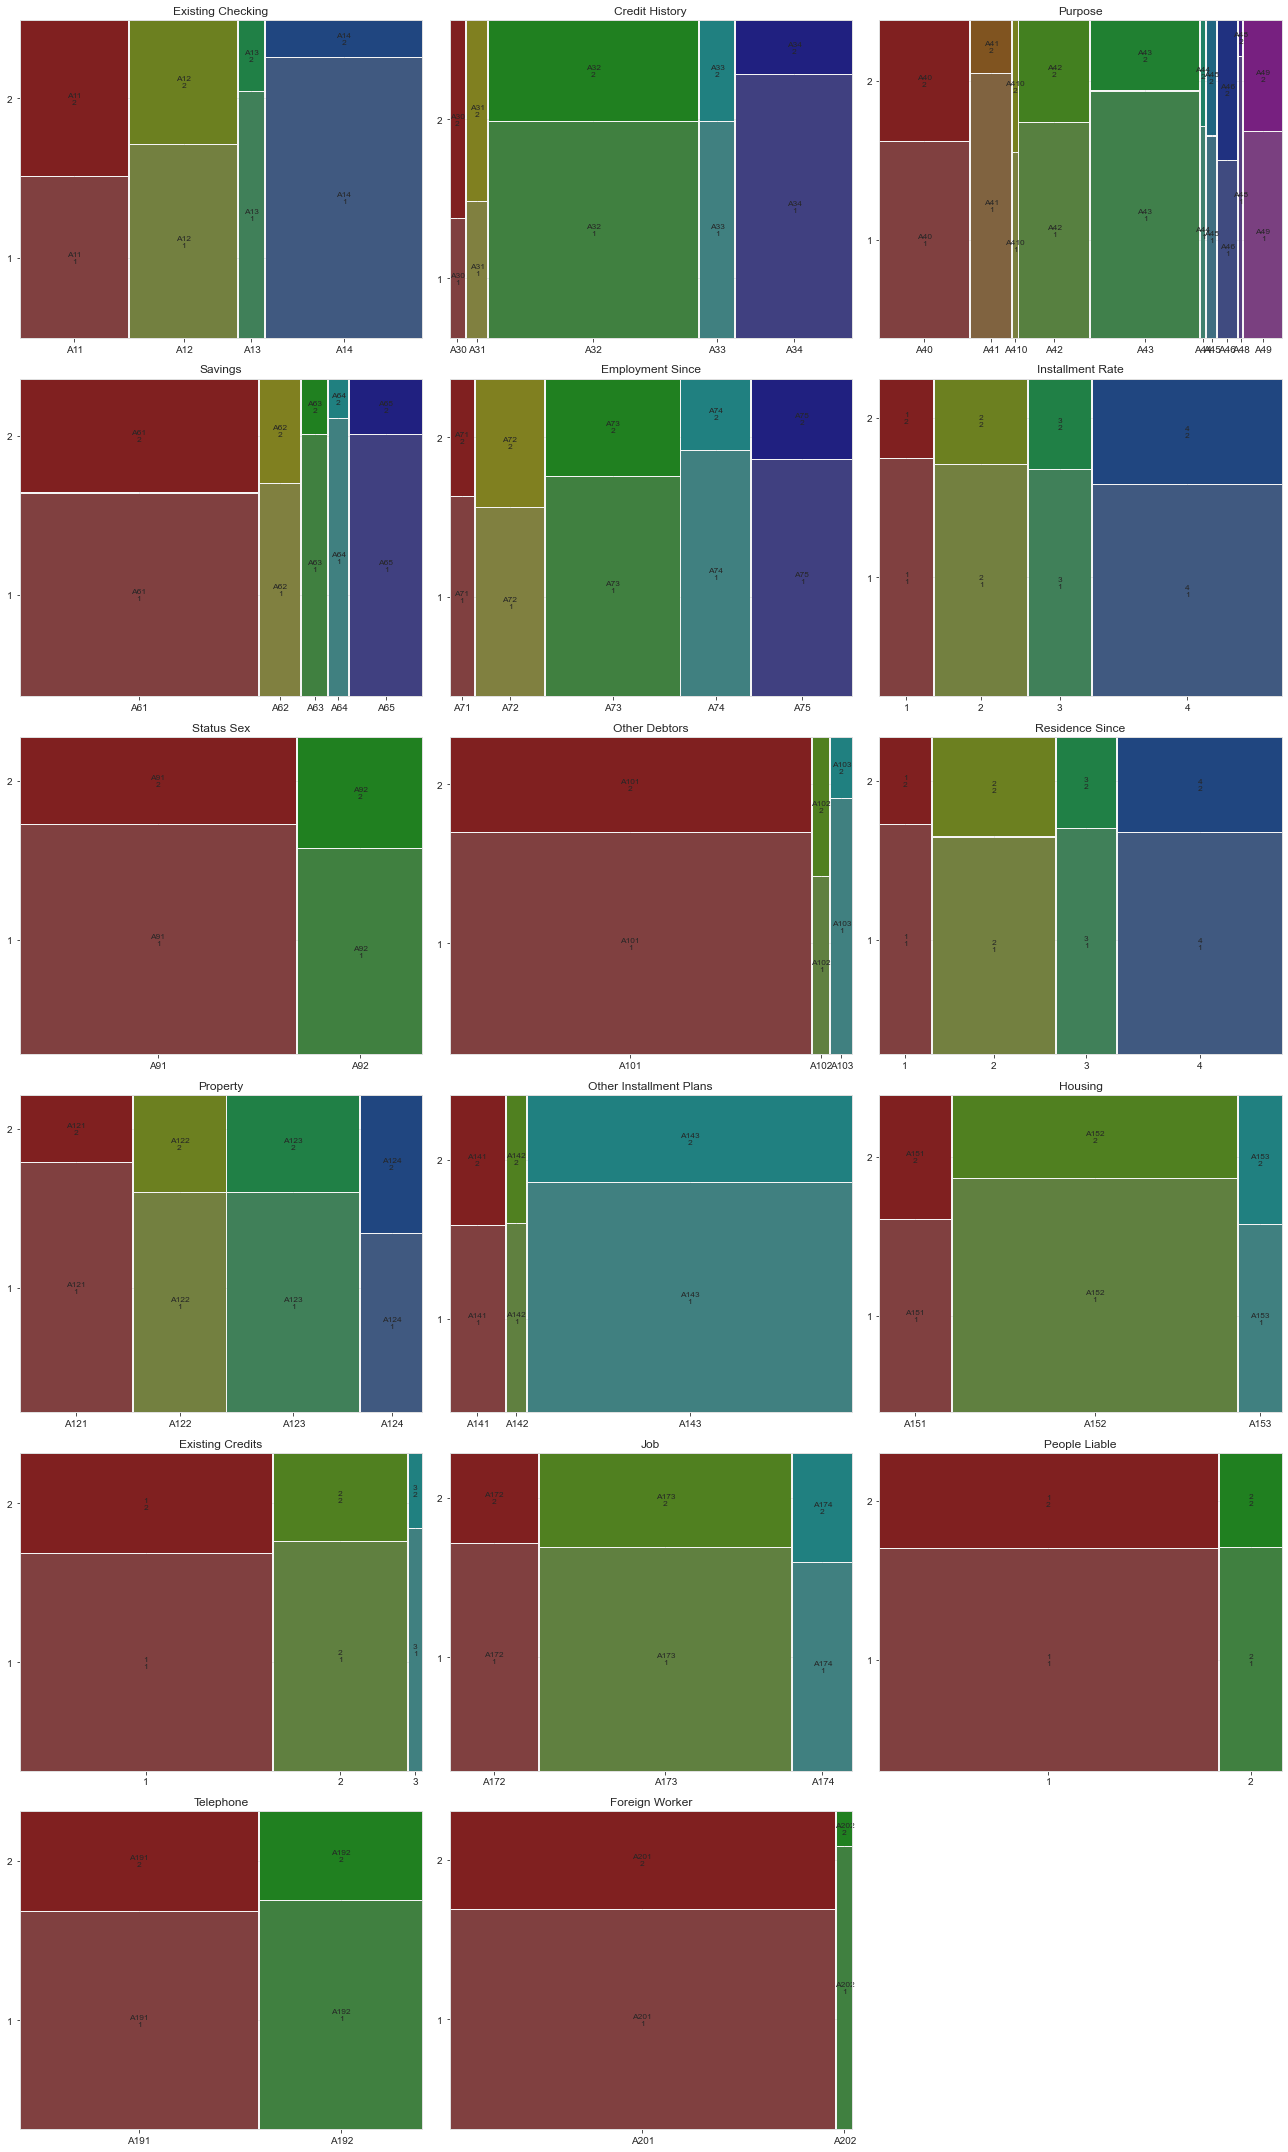

In [102]:
fig, axes = plt.subplots(6, 3, figsize=(18, 6 * 5))  
axes = axes.flatten()  

for idx, col in enumerate(column_names[:-1]):
    crosstable = pd.crosstab(df_comb[col], df_comb['Classification'])
    mosaic(crosstable.stack(), title=str(col), ax=axes[idx])

# Hide any unused subplots
for idx in range(len(column_names) - 1, len(axes)):
    fig.delaxes(axes[idx])
plt.tight_layout()
plt.show()

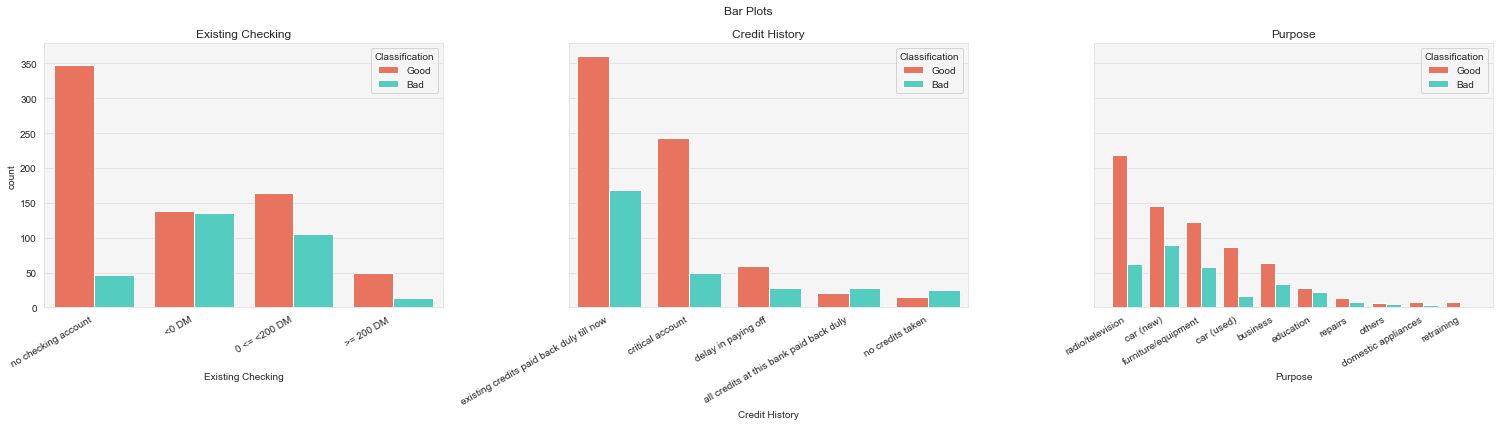

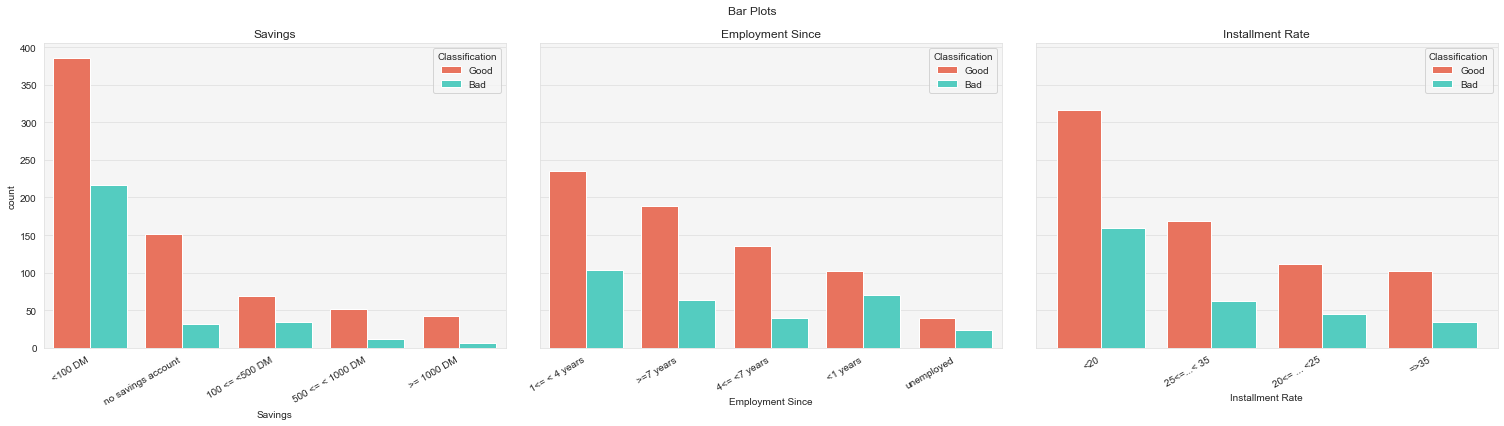

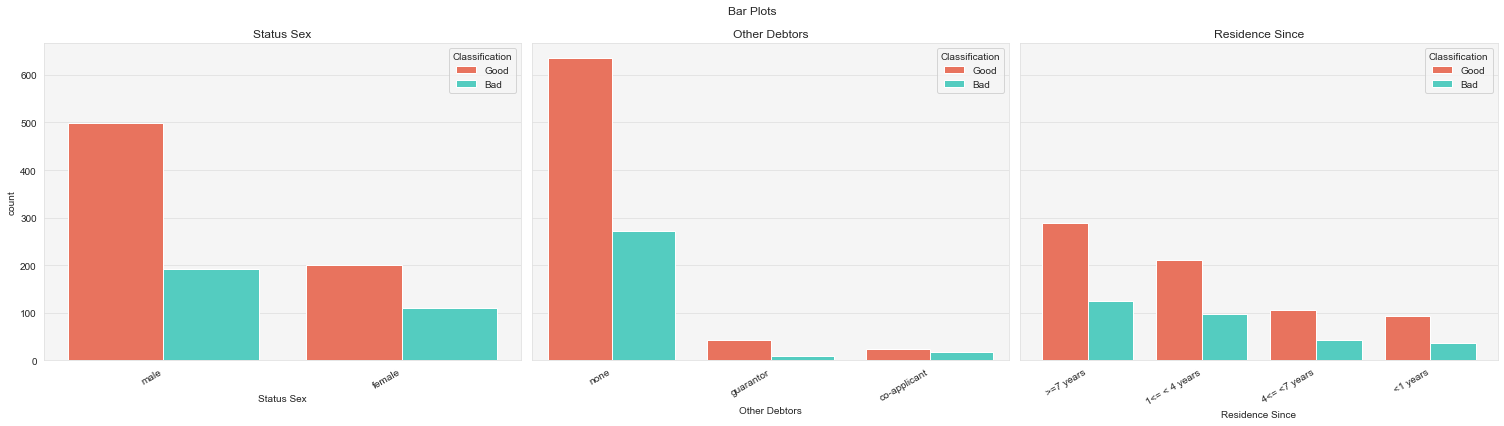

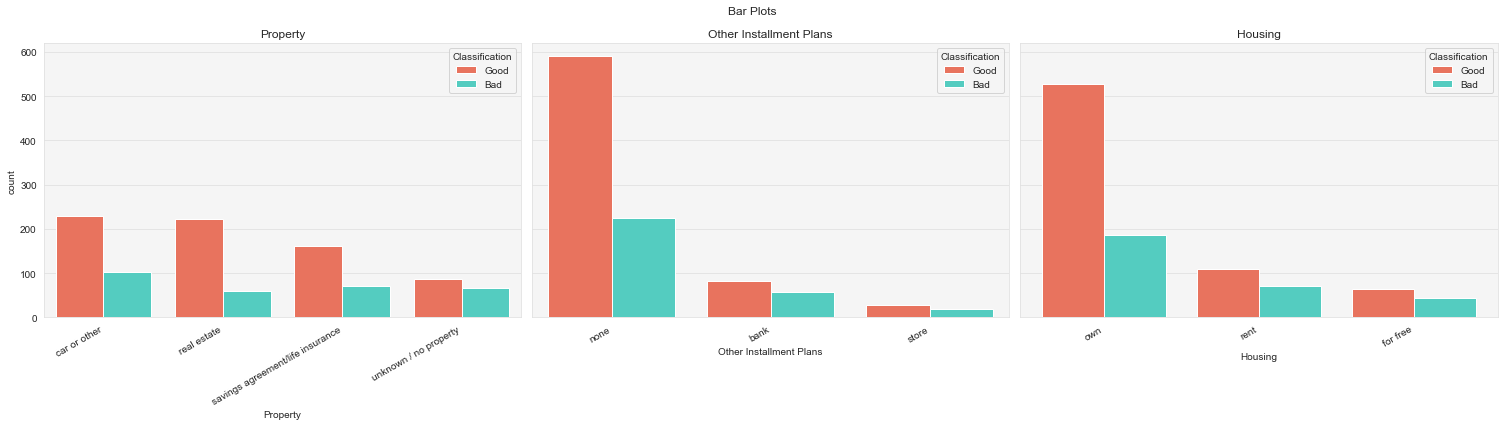

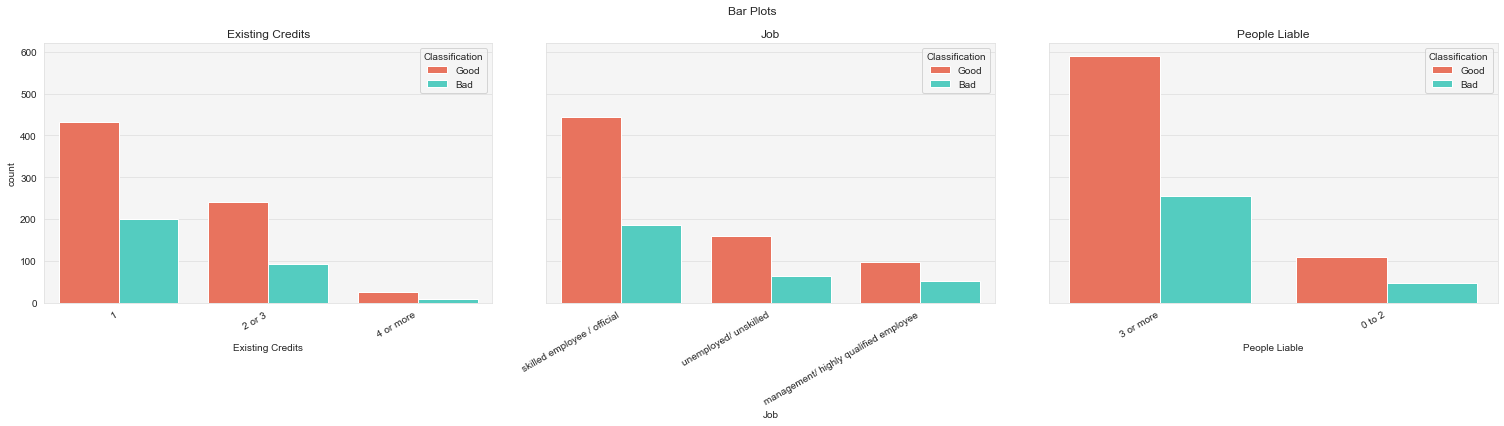

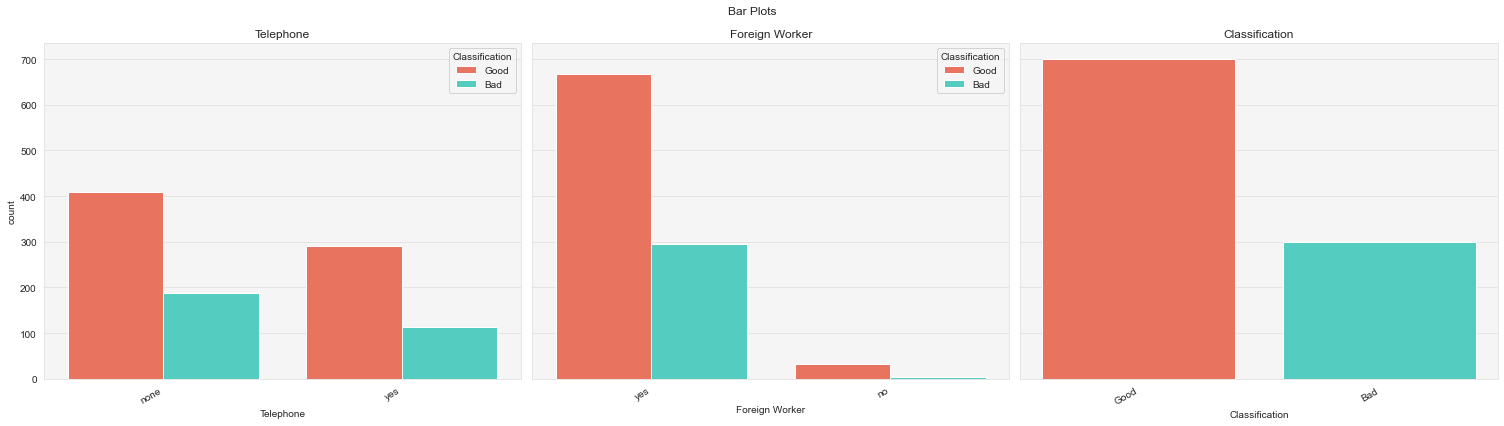

In [103]:
def plot_3_barplots_hue(chunk, data):

    fig, axes = plt.subplots(1, 3, figsize=(21, 6), sharey=True)
    fig.suptitle('Bar Plots')

    sns.countplot(ax=axes[0], x=chunk[0] , data = data, hue = "Classification",order = data[chunk[0]].value_counts().index)
    axes[0].set_title(chunk[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha="right")

    sns.countplot(ax=axes[1], x=chunk[1] , data = data, hue = "Classification", order = data[chunk[1]].value_counts().index)
    axes[1].set_title(chunk[1])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, ha="right")

    sns.countplot(ax=axes[2], x=chunk[2] , data = data, hue = "Classification", order = data[chunk[2]].value_counts().index)
    axes[2].set_title(chunk[2])
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30, ha="right")
    
    plt.tight_layout()
    plt.plot()

for i in chunks:
    plot_3_barplots_hue(i, df_copy2)

In case of these barplots we can check the ratio of each bar pair to see if a given feature effects the response variable. For example we can see that for  'Telephone' variable the ratio is very similar for each pair of bars. ('Bad' is around half the size of 'Good' bar). This suggest that these features do not effect the target variable 'Classification'.

Similar ratio: 
* Telephone, Job, Existing Credits, People Liable, Residence Since, Installment Rate.

Noticable differences in ratio:
* Existing Checking, Credit History , Purpose, Property, Employment Since.

Most propably features with noticable differences in ration will be best predictors, in other words they have good discriminative ablilities. I will check that in feature selection section.

# Feature Selection

## Continous Features - ANOVA test



Using Anova test we will check if there is a relationship between continuous variables and categorical target variable.

$H_0$ : There is no relation between the given variables

This is equivalent to the Students test, which should be used.

In [104]:
def Anova_test(data, target, feature_list):

    p_values = []
    for feature in feature_list:
        CategoryGroupLists=data.groupby(target)[feature].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        p_values.append(AnovaResults[1])

    dict_ = {'Feature' : feature_list, 'p-value': p_values}
    Anova_df = pd.DataFrame(dict_)
    return Anova_df

Anova_test(data=df_copy2, target='Classification', feature_list=numerical_col)

,Feature,p-value
0,Age,3.925339e-03
1,Duration,6.488050e-12
2,Credit Amount,8.797572e-07


Here we can see the results. All of the p-values are below 0.05, therefore we can reject the null hypothesis. This suggests that each continuous feature is corralated with target variable.

The decision is to keep all of the continuous features : 'Age', 'Duration', 'Credit Amount'.

## Categorical features - Chi-Square Test



In [105]:
categorical_col = column_names[:-1]

In [106]:
def Chisq_test(data, target, feature_list):
    
    p_values=[]
    corr = []

    for feature in feature_list:
        CrossTabResult=pd.crosstab(index=data[target], columns=data[feature])
        ChiSqResult = chi2_contingency(CrossTabResult)
        p_values.append(ChiSqResult[1])
        if ChiSqResult[1] < 0.05:
            corr.append("Yes")
        else:
            corr.append("No")

    dict_ = {'Feature' : feature_list, 'p-value': p_values, 'Is_corr': corr}
    Chi_df = pd.DataFrame(dict_) 
        
    return(Chi_df)

Chisq_result = Chisq_test(data=df_copy2, target='Classification', feature_list=categorical_col)

In [107]:
Chisq_result.sort_values(by='p-value')

,Feature,p-value,Is_corr
0,Existing Checking,1.218902e-26,Yes
1,Credit History,1.279187e-12,Yes
3,Savings,2.761214e-07,Yes
9,Property,2.858442e-05,Yes
11,Housing,1.116747e-04,Yes
2,Purpose,1.157491e-04,Yes
4,Employment Since,1.045452e-03,Yes
10,Other Installment Plans,1.629318e-03,Yes
16,Foreign Worker,1.583075e-02,Yes
6,Status Sex,2.073991e-02,Yes


Here we have the results for Chi-Square test, we can see that some features can be rejected. 

In [108]:
rejected_features = list(Chisq_result[Chisq_result['Is_corr']== "No"]['Feature'])
selected_features = list(Chisq_result[Chisq_result['Is_corr']== "Yes"]['Feature'])

print("There are ",  len(rejected_features),"rejected features: " ,rejected_features)
print("There are ", len(selected_features) ,"selected_features: ", selected_features)

There are  6 rejected features:  ['Installment Rate', 'Residence Since', 'Existing Credits', 'Job', 'People Liable', 'Telephone']
There are  11 selected_features:  ['Existing Checking', 'Credit History', 'Purpose', 'Savings', 'Employment Since', 'Status Sex', 'Other Debtors', 'Property', 'Other Installment Plans', 'Housing', 'Foreign Worker']


The rejected features confirm our conclusions based on paired barplots (in section Bivariate Analysis).

## Pre processing for Classification Algorithms

First I will load dataframe with the selected features.

In [109]:
df_comb_before_encoding = df_comb.copy()

In [110]:
selected = selected_features + numerical_col + ["Classification"]
selected

['Existing Checking',
 'Credit History',
 'Purpose',
 'Savings',
 'Employment Since',
 'Status Sex',
 'Other Debtors',
 'Property',
 'Other Installment Plans',
 'Housing',
 'Foreign Worker',
 'Age',
 'Duration',
 'Credit Amount',
 'Classification']

In [111]:
df_comb = df_comb[selected]

In [112]:
nominal = ["Housing", "Other Installment Plans", "Property", "Other Debtors", "Status Sex", "Purpose", "Credit History", 'Foreign Worker']

In [113]:
other = list(set(df_comb.columns) - set(nominal))

In [114]:
other

['Savings',
 'Age',
 'Existing Checking',
 'Classification',
 'Credit Amount',
 'Employment Since',
 'Duration']

In [115]:
df_comb[nominal]

,Housing,Other Installment Plans,Property,Other Debtors,Status Sex,Purpose,Credit History,Foreign Worker
0,A152,A143,A121,A101,A91,A43,A34,A201
1,A152,A143,A121,A101,A92,A43,A32,A201
2,A152,A143,A121,A101,A91,A46,A34,A201
3,A153,A143,A122,A103,A91,A42,A32,A201
4,A153,A143,A124,A101,A91,A40,A33,A201
...,...,...,...,...,...,...,...,...
995,A152,A143,A121,A101,A92,A42,A32,A201
996,A152,A143,A122,A101,A91,A41,A32,A201
997,A152,A143,A123,A101,A91,A43,A32,A201
998,A153,A143,A124,A101,A91,A43,A32,A201


In [116]:
# Binarize 'Classification' to : 0 = 'bad' credit; 1 = 'good' credit
df_comb['Classification'].replace([1,2], [0,1], inplace=True)

# ordinal 
#df_comb['Job'].replace(["A172", "A173", "A174"], [0,1,2], inplace=True)

df_comb['Employment Since'].replace(["A71", "A72", "A73", "A74", "A75"],[0,1,2,3,4], inplace = True)

df_comb['Savings'].replace(["A61", "A62", "A63", "A64", "A65"],[1,2,3,4,0], inplace = True)

df_comb['Existing Checking'].replace(["A11", "A12", "A13", "A14"],[1,2,3,0], inplace = True)

In [117]:
df_comb[other]

,Savings,Age,Existing Checking,Classification,Credit Amount,Employment Since,Duration
0,0,67,1,0,1169,4,6
1,1,22,2,1,5951,2,48
2,1,49,0,0,2096,3,12
3,1,45,1,0,7882,3,42
4,1,53,1,1,4870,2,24
...,...,...,...,...,...,...,...
995,1,31,0,0,1736,3,12
996,1,40,1,0,3857,2,30
997,1,38,0,0,804,4,12
998,1,23,1,1,1845,2,45


In [118]:
# Transforming categorical variables using dummies
df_comb_nominal=pd.get_dummies(df_comb[nominal], dtype=int)
df_comb_nominal

,Housing_A151,Housing_A152,Housing_A153,Other Installment Plans_A141,Other Installment Plans_A142,Other Installment Plans_A143,Property_A121,Property_A122,Property_A123,Property_A124,...,Purpose_A46,Purpose_A48,Purpose_A49,Credit History_A30,Credit History_A31,Credit History_A32,Credit History_A33,Credit History_A34,Foreign Worker_A201,Foreign Worker_A202
0,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,1,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,1,0
3,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
996,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
997,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
998,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [119]:
df_comb =  pd.concat([df_comb_nominal, df_comb[other] ], axis = 1)

df_comb.columns

Index(['Housing_A151', 'Housing_A152', 'Housing_A153',
       'Other Installment Plans_A141', 'Other Installment Plans_A142',
       'Other Installment Plans_A143', 'Property_A121', 'Property_A122',
       'Property_A123', 'Property_A124', 'Other Debtors_A101',
       'Other Debtors_A102', 'Other Debtors_A103', 'Status Sex_A91',
       'Status Sex_A92', 'Purpose_A40', 'Purpose_A41', 'Purpose_A410',
       'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45',
       'Purpose_A46', 'Purpose_A48', 'Purpose_A49', 'Credit History_A30',
       'Credit History_A31', 'Credit History_A32', 'Credit History_A33',
       'Credit History_A34', 'Foreign Worker_A201', 'Foreign Worker_A202',
       'Savings', 'Age', 'Existing Checking', 'Classification',
       'Credit Amount', 'Employment Since', 'Duration'],
      dtype='object')

## Spliting Data into Training and Test

In [120]:
# target
Target = 'Classification'

# all column with predictors
Predictors = list(df_comb.columns)
Predictors.remove('Classification')

print("Number of predictors :" ,len(Predictors))

Number of predictors : 38


In [121]:
X = df_comb[Predictors].values
y = df_comb[Target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_raw = X_train
X_test_raw = X_test

# Scaling 

In [122]:
PredictorScaler=StandardScaler()
X_train = PredictorScaler.fit_transform(X_train)
X_test = PredictorScaler.transform(X_test)

# Dealing with Class Imbalance Problem - Sampling 


## Using ADASYN

In [123]:
ada = ADASYN()

X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

print("Shape of the balanced ADASYN dataset is: ", X_train_ada.shape)

pos_ratio = y_train_ada[y_train_ada==1].shape[0]/y_train_ada.shape[0]
neg_ratio = y_train_ada[y_train_ada==0].shape[0]/y_train_ada.shape[0]

print("Proportion of positive samples in the balanced training set: " ,pos_ratio)
print("Proportion of negative samples in the balanced training set: " ,neg_ratio)

Shape of the balanced ADASYN dataset is:  (983, 38)
Proportion of positive samples in the balanced training set:  0.5005086469989827
Proportion of negative samples in the balanced training set:  0.49949135300101727


# Logistic Regression

### Calculating feature importance

The simplest way to calculate feature importance in logistic regression is using the model’s coefficients. The coefficients represent the change in the log odds for a one-unit change in the predictor variable. Larger absolute values indicate a stronger relationship between the predictor and the target variable.

Using this way of feature selection it is important to mention that the data should be scaled, since the model may give higher coefficients (thus higher importance) to the features with larger values, even if they are not necessarily more important.
When the features are standardized, the magnitude of the coefficients in logistic regression directly reflects the importance of each feature.
The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.


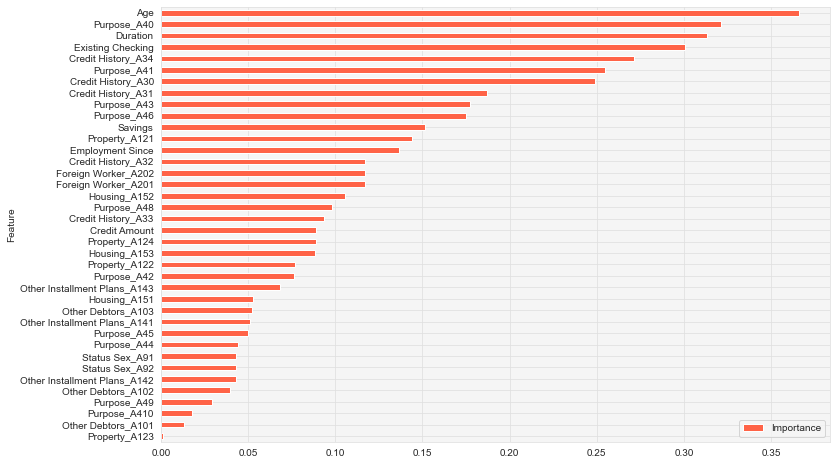

In [127]:
def importance_plot(model, X_train, y_train):
    
    model.fit(X_train, y_train)
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({'Feature': Predictors, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(12, 8))
    ax.legend(loc='lower right')
    plt.show()

    return feature_importance

LR = LogisticRegression()
LR_FI = importance_plot(LR, X_train, y_train)


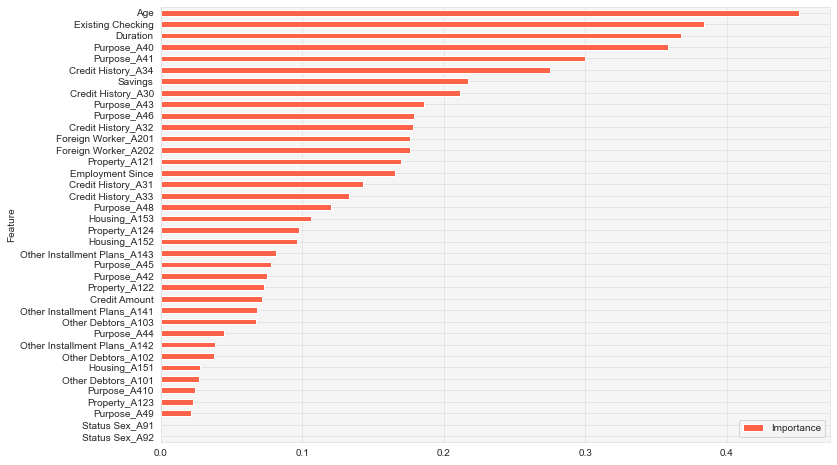

In [128]:
LR_FI_ada = importance_plot(LR, X_train_ada, y_train_ada)

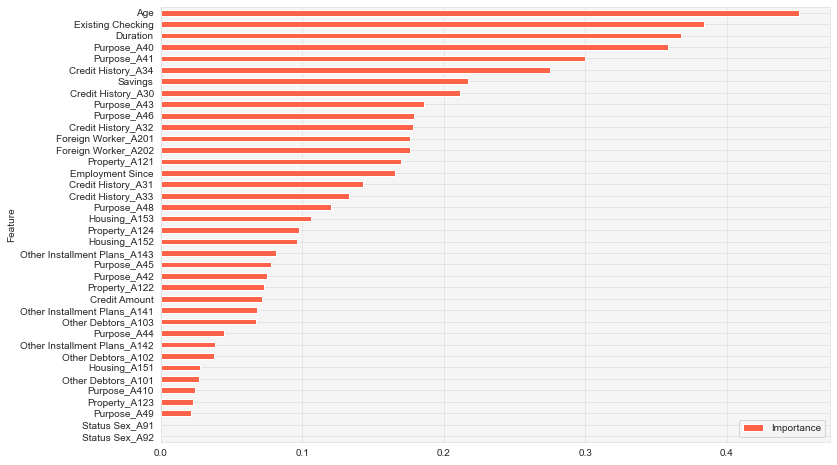

In [129]:
LR_FI_ada = importance_plot(LR, X_train_ada, y_train_ada)

In [130]:
top7_LR = list(LR_FI_ada.sort_values(by='Importance', ascending=False).head(7)['Feature'])
top14_LR = list(LR_FI_ada.sort_values(by='Importance', ascending=False).head(14)['Feature'])
top21_LR = list(LR_FI_ada.sort_values(by='Importance', ascending=False).head(21)['Feature'])

### Choosing feature subsets based on Importance Plots

In [131]:
# top 7 features subset
X_top7_LR = df_comb[top7_LR].values
X_train_top7_LR, X_test_top7_LR, y_train_top7_LR, y_test_top7_LR = train_test_split(X_top7_LR , y, test_size=0.3, random_state=42)
X_train_top7_LR = PredictorScaler.fit_transform(X_train_top7_LR)
X_test_top7_LR = PredictorScaler.transform(X_test_top7_LR)

# with ADASYN
X_train_top7_LR_ada, y_train_top7_LR_ada = ada.fit_resample(X_train_top7_LR,y_train_top7_LR)

# top 14 features subset
X_top14_LR = df_comb[top14_LR].values
X_train_top14_LR, X_test_top14_LR, y_train_top14_LR, y_test_top14_LR = train_test_split(X_top14_LR , y, test_size=0.3, random_state=42)
X_train_top14_LR = PredictorScaler.fit_transform(X_train_top14_LR)
X_test_top14_LR = PredictorScaler.transform(X_test_top14_LR)

# with ADASYN
X_train_top14_LR_ada, y_train_top14_LR_ada = ada.fit_resample(X_train_top14_LR,y_train_top14_LR)

# top 21 features subset
X_top21_LR = df_comb[top21_LR].values
X_train_top21_LR, X_test_top21_LR, y_train_top21_LR, y_test_top21_LR = train_test_split(X_top21_LR , y, test_size=0.3, random_state=42)
X_train_top21_LR = PredictorScaler.fit_transform(X_train_top21_LR)
X_test_top21_LR = PredictorScaler.transform(X_test_top21_LR)

# with ADASYN
X_train_top21_LR_ada, y_train_top21_LR_ada = ada.fit_resample(X_train_top21_LR,y_train_top21_LR)


## Training and testing functions

In [132]:
def conf_matrix_plot_list(conf_matrix_list, model_name_list): 

    """" Function plots 2x2 grid with 4 confusion matrices """
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    sns.heatmap(conf_matrix_list[0], annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g", ax=ax[0,0])
    ax[0,0].set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax[0,0].set_xlabel("predicted")
    ax[0,0].set_ylabel("actual")
    ax[0,0].set_title(str("Confusion matrix " + model_name_list[0]))

    sns.heatmap( conf_matrix_list[1], annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g", ax=ax[0,1])
    ax[0,1].set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax[0,1].set_xlabel("predicted")
    ax[0,1].set_ylabel("actual")
    ax[0,1].set_title(str("Confusion matrix " + model_name_list[1]))

    sns.heatmap(conf_matrix_list[2], annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g", ax=ax[1,0])
    ax[1,0].set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax[1,0].set_xlabel("predicted")
    ax[1,0].set_ylabel("actual")
    ax[1,0].set_title(str("Confusion matrix " + model_name_list[2]))

    sns.heatmap( conf_matrix_list[3], annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g",ax=ax[1,1])
    ax[1,1].set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax[1,1].set_xlabel("predicted")
    ax[1,1].set_ylabel("actual")
    ax[1,1].set_title(str("Confusion matrix " + model_name_list[3]))
    plt.show()

def conf_matrix_plot(conf_matrix, model_name): #confusion_matrix_list, _model_name_list

    "Function displays confusion matrix as heatmap"

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(conf_matrix, annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g")
    ax.set_yticklabels(labels=["good", "bad"], rotation=0) 
    ax.set_xlabel("predicted")
    ax.set_ylabel("actual")
    ax.set_title(str("Confusion matrix " + model_name))
    plt.show()
     

def plot_roc(roc, roc_auc, model_name):

    " Function plots roc curve"

    fig, ax = plt.subplots(figsize=(7, 5))
    plt.plot(roc[0],roc[1],label="auc="+str(roc_auc))
    plt.plot([0,1], [0,1], color = "black")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(model_name)
    plt.legend(loc=4)
    plt.show()


def trainClassifier(X_train, y_train, model_name, classifier, params):

    "function for training a Classifier and finding best parameters"
    
    # performing GridSearch with 10 fold CV to tune the model
    kf = StratifiedKFold(10)
    train_scores = []
    best_score = 0
        
    for config in ParameterGrid(params):
        train_scores_run = []
        counts = []
        for train_indices, valid_indices in kf.split(X_train, y_train):
            counts.append(len(train_indices))
            X_train_kf = X_train[train_indices]
            y_train_kf = y_train[train_indices]
            X_valid_kf = X_train[valid_indices]
            y_valid_kf = y_train[valid_indices]

            model = classifier(**config)
            model.fit(X_train_kf, y_train_kf)
            y_hat = model.predict(X_valid_kf)
            train_score = accuracy_score(y_valid_kf, y_hat) # fbeta 2 
            train_scores_run.append(train_score)


        if np.average(train_scores_run, weights=counts) > best_score:
            best_score = np.average(train_scores_run, weights=counts)
            best_config = config

        train_scores.append(np.average(train_scores_run, weights=counts))

    output_df = pd.DataFrame(data = [[model_name, best_config ,best_score]], \
        columns=["model_name", "parameters", "training_score (acc)"])
    
    print(best_config)

    return output_df, best_config


def testClassifier(X_train, y_train, X_test, y_test, classifier, best_params, proba=False):
    
    """Function for testing the Classifier, 
    returns: output_df :  dataframe with scores
            roc : a tuple with [false positive , true positive]
            roc_auc: the auc value
            conf_matrix: confusion matrix"""

    best_model = classifier(**best_params)
    best_model.fit(X_train, y_train)

    
    y_hat = best_model.predict(X_test)

    # f1 score
    f1_test = f1_score(y_test, y_hat)
    
    # f2 score
    f2_test = fbeta_score(y_test, y_hat, beta=2)

    # Accuracy
    accuracy_test = accuracy_score(y_test, y_hat)

    conf_matrix = confusion_matrix(y_test, y_hat)

    tn, fp, fn, tp = conf_matrix.ravel()
    cost = 0 * tn + 1 * fp + 5* fn + 0 * tp

    # specificity
    specificity = tn / (tn+fp)

    #sensitivity
    sensitivity = tp / (tp + fn)


    if proba == False:
        y_score = best_model.decision_function(X_test)
    else:
        y_score = best_model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    roc = [fpr, tpr] 

    output_df = pd.DataFrame(data=[[f1_test, f2_test, accuracy_test, specificity, sensitivity, cost]],\
        columns=["f1_test", "f2_test", "accuracy_test" ,"specificity", "sensitivity","cost"])
    
    return output_df, roc, roc_auc, conf_matrix

def model_results(X_train, y_train, X_test, y_test, model_name, classifier, params, proba):

    "function trains and test a Classifier, prepares the results "

    df_res1, best_params = trainClassifier(X_train, y_train, model_name , classifier , params)

    df_res2, roc, roc_auc, conf_matrix = testClassifier(X_train, y_train, X_test, y_test, classifier, best_params, proba=proba)

    df_full = pd.concat([df_res1, df_res2 ], axis = 1)

    return df_full, conf_matrix, roc, roc_auc


## Logistic Regression results

In [133]:
param_grid =    {
    'C' : np.logspace(-4, 4, 20)}

df_full_LG_top7, conf_matrix_LG_top7, roc_LG_top7, roc_auc_LG_top7= model_results(X_train_top7_LR, y_train_top7_LR, X_test_top7_LR, y_test_top7_LR, "Logistic Regression Top7", LogisticRegression, param_grid, proba=True)

{'C': 0.08858667904100823}


In [134]:
df_full_LG_top14, conf_matrix_LG_top14, roc_LG_top14, roc_auc_LG_top14 = model_results(X_train_top14_LR, y_train_top14_LR, X_test_top14_LR, y_test_top14_LR, "Logistic Regression Top14", LogisticRegression, param_grid, proba=True)

{'C': 0.08858667904100823}


In [135]:
df_full_LG_top21, conf_matrix_LG_top21, roc_LG_top21, roc_auc_LG_top21 = model_results(X_train_top21_LR, y_train_top21_LR, X_test_top21_LR, y_test_top21_LR, "Logistic Regression Top21", LogisticRegression, param_grid, proba=True)

{'C': 4.281332398719396}


In [136]:
df_full_LG, conf_matrix_LG, roc_LG, roc_auc_LG = model_results(X_train, y_train, X_test, y_test, "Logistic Regression All Features", LogisticRegression, param_grid, proba=True)

{'C': 0.08858667904100823}


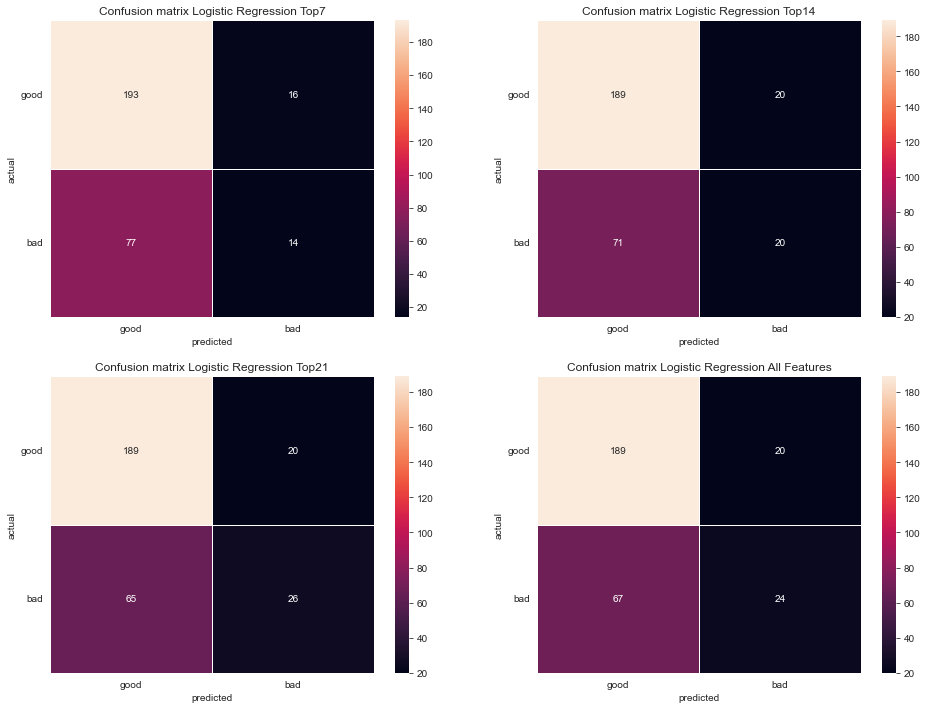

In [137]:
conf_matrix_plot_list([conf_matrix_LG_top7,conf_matrix_LG_top14, conf_matrix_LG_top21,conf_matrix_LG],["Logistic Regression Top7", "Logistic Regression Top14", "Logistic Regression Top21", "Logistic Regression All Features"])

In [138]:
LG_summary = pd.concat([df_full_LG_top7, df_full_LG_top14, df_full_LG_top21, df_full_LG], axis = 0)
LG_summary

,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,Logistic Regression Top7,{'C': 0.08858667904100823},0.714286,0.231405,0.177665,0.690000,0.923445,0.153846,401
0,Logistic Regression Top14,{'C': 0.08858667904100823},0.727143,0.305344,0.247525,0.696667,0.904306,0.219780,375
0,Logistic Regression Top21,{'C': 4.281332398719396},0.741429,0.379562,0.317073,0.716667,0.904306,0.285714,345
0,Logistic Regression All Features,{'C': 0.08858667904100823},0.735714,0.355556,0.294118,0.710000,0.904306,0.263736,355


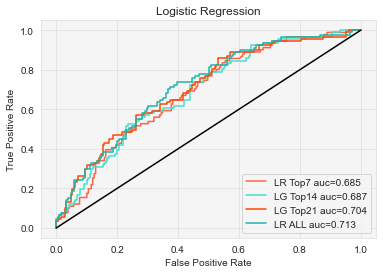

In [139]:
labels = ["LR Top7", "LG Top14", "LG Top21", "LR ALL"]
rocs = [roc_LG_top7, roc_LG_top14, roc_LG_top21, roc_LG]
aucs = [roc_auc_LG_top7,roc_auc_LG_top14, roc_auc_LG_top21, roc_auc_LG]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression")
plt.legend(loc=4)
plt.show()

## Logistic regression with ADASYN

In [140]:
df_full_LG_top7_ada, conf_matrix_LG_top7_ada, roc_LG_top7_ada, roc_auc_LG_top7_ada= model_results(X_train_top7_LR_ada, y_train_top7_LR_ada, X_test_top7_LR, y_test_top7_LR, "Logistic Regression Top7 ADASYN", LogisticRegression, param_grid, proba=True)

{'C': 0.0018329807108324356}


In [141]:
df_full_LG_top14_ada, conf_matrix_LG_top14_ada, roc_LG_top14_ada, roc_auc_LG_top14_ada= model_results(X_train_top14_LR_ada, y_train_top14_LR_ada, X_test_top14_LR, y_test_top14_LR, "Logistic Regression Top14 ADASYN", LogisticRegression, param_grid, proba=True)

{'C': 0.23357214690901212}


In [142]:
df_full_LG_top21_ada, conf_matrix_LG_top21_ada, roc_LG_top21_ada, roc_auc_LG_top21_ada= model_results(X_train_top21_LR_ada, y_train_top21_LR_ada, X_test_top21_LR, y_test_top21_LR, "Logistic Regression Top21 ADASYN", LogisticRegression, param_grid, proba=True)

{'C': 0.23357214690901212}


In [143]:
df_full_LG_ada, conf_matrix_LG_ada, roc_LG_ada, roc_auc_LG_ada = model_results(X_train_ada, y_train_ada, X_test, y_test, "Logistic Regression All Features ADASYN", LogisticRegression, param_grid, proba=True)

{'C': 0.012742749857031334}


In [144]:
LG_summary_ada = pd.concat([df_full_LG_top7_ada, df_full_LG_top14_ada, df_full_LG_top21_ada, df_full_LG_ada], axis = 0)
LG_summary_ada

,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,Logistic Regression Top7 ADASYN,{'C': 0.0018329807108324356},0.661582,0.509225,0.634191,0.556667,0.468900,0.758242,221
0,Logistic Regression Top14 ADASYN,{'C': 0.23357214690901212},0.683699,0.500000,0.534591,0.660000,0.703349,0.560440,262
0,Logistic Regression Top21 ADASYN,{'C': 0.23357214690901212},0.689179,0.485437,0.521921,0.646667,0.688995,0.549451,270
0,Logistic Regression All Features ADASYN,{'C': 0.012742749857031334},0.709026,0.523364,0.574949,0.660000,0.679426,0.615385,242


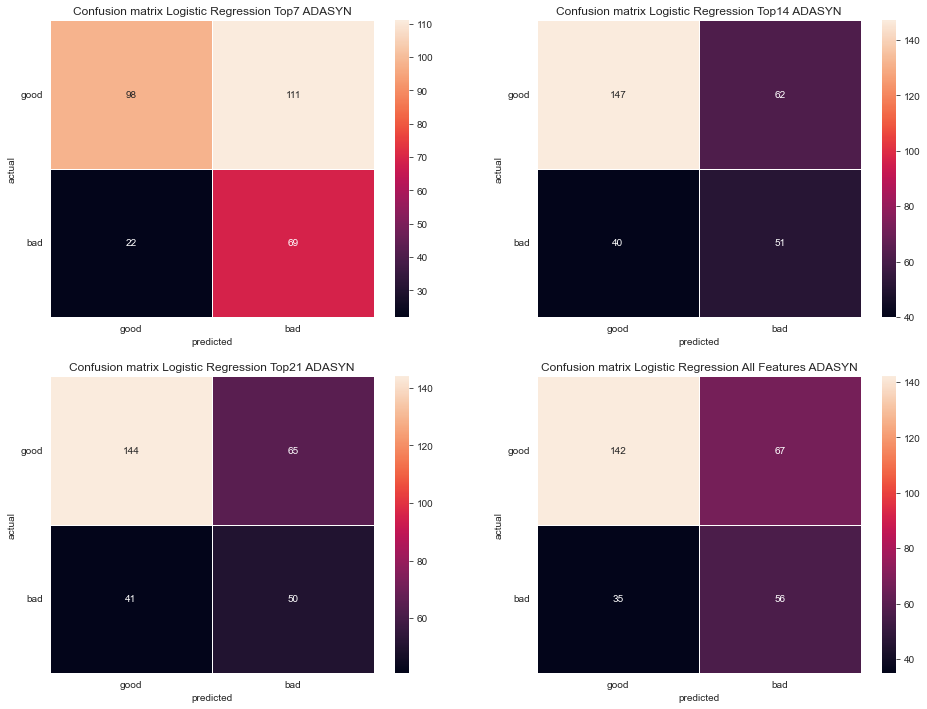

In [145]:
conf_matrix_plot_list([conf_matrix_LG_top7_ada,conf_matrix_LG_top14_ada, conf_matrix_LG_top21_ada,conf_matrix_LG_ada],["Logistic Regression Top7 ADASYN", "Logistic Regression Top14 ADASYN", "Logistic Regression Top21 ADASYN", "Logistic Regression All Features ADASYN"])

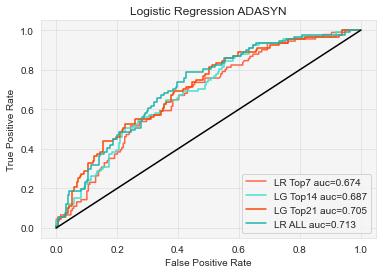

In [146]:
labels = ["LR Top7", "LG Top14", "LG Top21", "LR ALL"]
rocs = [roc_LG_top7_ada, roc_LG_top14_ada, roc_LG_top21_ada, roc_LG_ada]
aucs = [roc_auc_LG_top7_ada,roc_auc_LG_top14_ada, roc_auc_LG_top21_ada, roc_auc_LG_ada]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ADASYN")
plt.legend(loc=4)
plt.show()

# KNN

### Feature Importance

In order to analyze feature importance for KNN model I have decided to use an embeded method - Lasso regularization. 

In [147]:
skf = StratifiedKFold(n_splits=5)
model  = LassoCV(cv=skf, random_state=42)
model.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % model.alpha_)
print("Best score using built-in LassoCV: %f" %model.score(X_train,y_train))
coef = pd.DataFrame({'Feature': Predictors, 'Importance': model.coef_})

Best alpha using built-in LassoCV: 0.011096
Best score using built-in LassoCV: 0.194832


Lasso picked 22 variables and eliminated the other 16 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

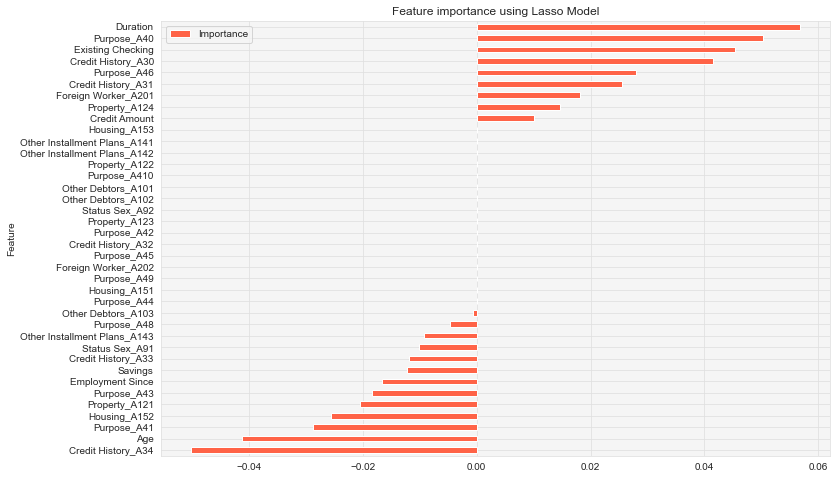

In [148]:
print("Lasso picked " + str(sum(coef['Importance'] != 0)) + " variables and eliminated the other " +  str(sum(coef['Importance'] == 0)) + " variables")
imp_coef = coef.sort_values(by = 'Importance', ascending=True)
# import matplotlib
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(x='Feature', y='Importance', kind='barh', figsize=(12, 8))
plt.title("Feature importance using Lasso Model")

In [149]:
imp_coef['Importance abs'] = abs(imp_coef['Importance'])

In [150]:
KNN_chosen_features = ['Property_A121', 'Property_A122', 'Property_A123', 'Property_A124', 
                       'Purpose_A40', 'Purpose_A41', 'Purpose_A410', 'Purpose_A42', 'Purpose_A43', 'Purpose_A44', 'Purpose_A45', 'Purpose_A46', 'Purpose_A48', 'Purpose_A49',
                       'Credit History_A30','Credit History_A31','Credit History_A32','Credit History_A33','Credit History_A34',
                       'Existing Checking',
                       'Savings',
                       'Credit Amount',
                       'Duration']
KNN_lasso_features = list(imp_coef.sort_values(by='Importance abs', ascending=False).head(23)['Feature'])

In [151]:
KNN_intersection_features = [x for x in KNN_lasso_features if x in KNN_chosen_features]
len(KNN_intersection_features)

15

In [152]:
KNN_intersection_features

['Duration',
 'Purpose_A40',
 'Credit History_A34',
 'Existing Checking',
 'Credit History_A30',
 'Purpose_A41',
 'Purpose_A46',
 'Credit History_A31',
 'Property_A121',
 'Purpose_A43',
 'Property_A124',
 'Savings',
 'Credit History_A33',
 'Credit Amount',
 'Purpose_A48']

In [153]:
# top Lasso feature subset
X_top_Lasso_KNN = df_comb[KNN_lasso_features].values

X_train_Lasso_KNN, X_test_Lasso_KNN, y_train_Lasso_KNN, y_test_Lasso_KNN = train_test_split(X_top_Lasso_KNN , y, test_size=0.3, random_state=42)
X_train_Lasso_KNN = PredictorScaler.fit_transform(X_train_Lasso_KNN)
X_test_Lasso_KNN = PredictorScaler.transform(X_test_Lasso_KNN)

# with ADASYN
X_train_Lasso_KNN_ada, y_train_Lasso_KNN_ada = ada.fit_resample(X_train_Lasso_KNN,y_train_Lasso_KNN)

# top features based on EDA
X_top_Chosen_KNN = df_comb[KNN_chosen_features].values

X_train_Chosen_KNN, X_test_Chosen_KNN, y_train_Chosen_KNN, y_test_Chosen_KNN = train_test_split(X_top_Chosen_KNN , y, test_size=0.3, random_state=42)
X_train_Chosen_KNN = PredictorScaler.fit_transform(X_train_Chosen_KNN)
X_test_Chosen_KNN = PredictorScaler.transform(X_test_Chosen_KNN)

# with ADASYN
X_train_Chosen_KNN_ada, y_train_Chosen_KNN_ada = ada.fit_resample(X_train_Chosen_KNN,y_train_Chosen_KNN)

# top features both in EDA and Lasso
X_top_Inter_KNN= df_comb[KNN_intersection_features].values
X_train_Inter_KNN, X_test_Inter_KNN, y_train_Inter_KNN, y_test_Inter_KNN = train_test_split(X_top_Inter_KNN , y, test_size=0.3, random_state=42)
X_train_Inter_KNN = PredictorScaler.fit_transform(X_train_Inter_KNN)
X_test_Inter_KNN = PredictorScaler.transform(X_test_Inter_KNN)

# with ADASYN
X_train_Inter_KNN_ada, y_train_Inter_KNN_ada = ada.fit_resample(X_train_Inter_KNN,y_train_Inter_KNN)

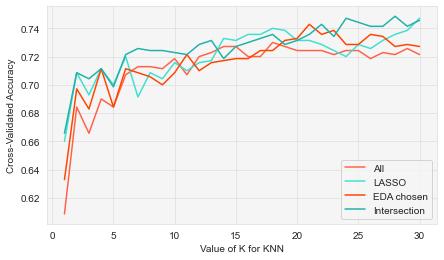

In [154]:
plt.rcParams['figure.figsize'] = (7, 4)

k_range = list(range(1, 31))
k_scores_all = []
k_scores_lasso = []
k_scores_chosen = []
k_scores_inter = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # all features
    scores_all = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores_all.append(scores_all.mean())

    # lasso subset
    scores_lasso = cross_val_score(knn, X_train_Lasso_KNN, y_train_Lasso_KNN, cv=10, scoring='accuracy')
    k_scores_lasso.append(scores_lasso.mean())

    # eda chosen subset
    scores_chosen = cross_val_score(knn, X_train_Chosen_KNN, y_train_Chosen_KNN, cv=10, scoring='accuracy')
    k_scores_chosen.append(scores_chosen.mean())

    # intersection subset
    scores_inter = cross_val_score(knn, X_train_Inter_KNN, y_train_Inter_KNN, cv=10, scoring='accuracy')
    k_scores_inter.append(scores_inter.mean())

plt.plot(k_range, k_scores_all, label = "All")
plt.plot(k_range, k_scores_lasso, label = "LASSO")
plt.plot(k_range, k_scores_chosen, label = "EDA chosen")
plt.plot(k_range, k_scores_inter, label = "Intersection")
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.show()

## KNN with All Features

In [155]:
params = { 'n_neighbors' : [5,6,7,8,9,10,11,12,13,14,15,16],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

df_full_knn, conf_matrix_knn, roc_knn, roc_auc_knn = model_results(X_train, y_train, X_test, y_test, "KNN All Features", KNeighborsClassifier, params, proba=True)

{'metric': 'minkowski', 'n_neighbors': 14, 'weights': 'uniform'}


## KNN with Lasso chosen Features

In [156]:
df_full_knn_Lasso, conf_matrix_knn_Lasso, roc_knn_Lasso, roc_auc_knn_Lasso = model_results(X_train_Lasso_KNN, y_train_Lasso_KNN, X_test_Lasso_KNN, y_test_Lasso_KNN, "KNN Lasso Features", KNeighborsClassifier, params, proba=True)

{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}


## KNN with EDA chosen Features


In [157]:
df_full_knn_Chosen, conf_matrix_knn_Chosen, roc_knn_Chosen, roc_auc_knn_Chosen = model_results(X_train_Chosen_KNN, y_train_Chosen_KNN, X_test_Chosen_KNN, y_test_Chosen_KNN, "KNN EDA Features", KNeighborsClassifier, params, proba=True)

{'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'distance'}


## KNN with Intersection Features

In [158]:
df_full_knn_Inter, conf_matrix_knn_Inter, roc_knn_Inter, roc_auc_knn_Inter = model_results(X_train_Inter_KNN, y_train_Inter_KNN, X_test_Inter_KNN, y_test_Inter_KNN, "KNN Intersection Features", KNeighborsClassifier, params, proba=True)

{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}


In [159]:
KNN_summary = pd.concat([df_full_knn, df_full_knn_Lasso, df_full_knn_Chosen, df_full_knn_Inter ], axis = 0)
KNN_summary

,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,KNN All Features,"{'metric': 'minkowski', 'n_neighbors': 14, 'we...",0.727143,0.201835,0.143979,0.710000,0.966507,0.120879,407
0,KNN Lasso Features,"{'metric': 'manhattan', 'n_neighbors': 16, 'we...",0.747143,0.308943,0.239899,0.716667,0.937799,0.208791,373
0,KNN EDA Features,"{'metric': 'manhattan', 'n_neighbors': 16, 'we...",0.731429,0.389262,0.343602,0.696667,0.861244,0.318681,339
0,KNN Intersection Features,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.750000,0.373134,0.307125,0.720000,0.913876,0.274725,348


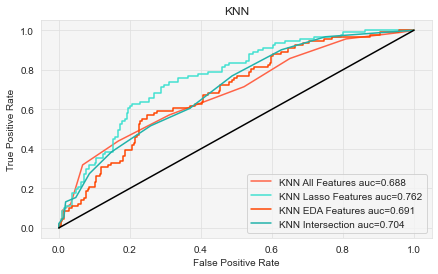

In [160]:
labels = ["KNN All Features", "KNN Lasso Features", "KNN EDA Features", "KNN Intersection"]
rocs = [roc_knn, roc_knn_Lasso, roc_knn_Chosen, roc_knn_Inter]
aucs = [roc_auc_knn,roc_auc_knn_Lasso, roc_auc_knn_Chosen, roc_auc_knn_Inter]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN")
plt.legend(loc=4)
plt.show()

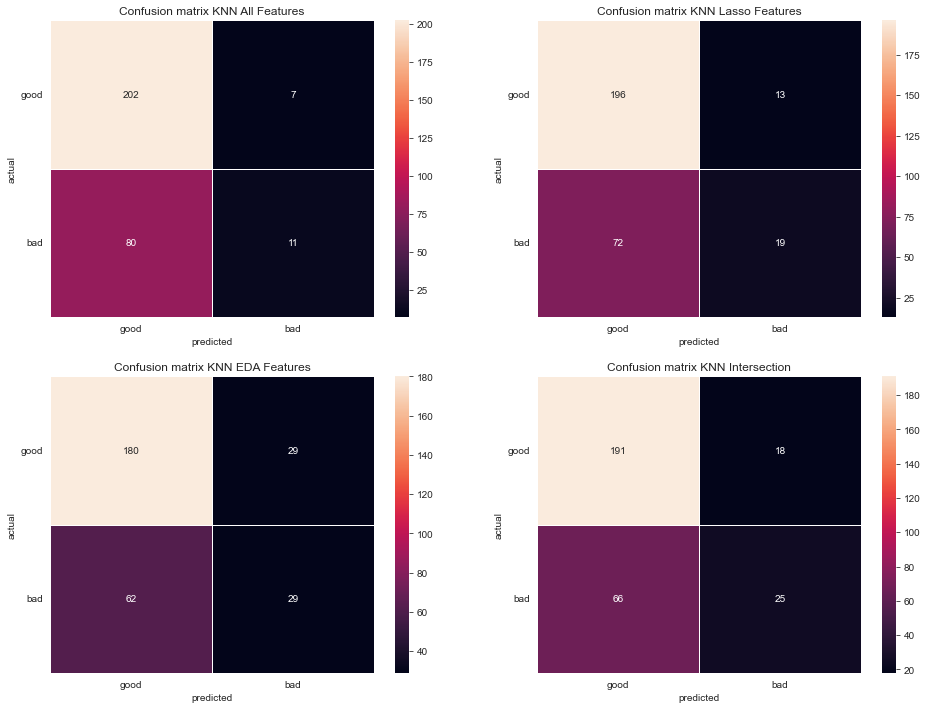

In [161]:
conf_matrix_plot_list([conf_matrix_knn,conf_matrix_knn_Lasso, conf_matrix_knn_Chosen,conf_matrix_knn_Inter],["KNN All Features", "KNN Lasso Features", "KNN EDA Features", "KNN Intersection"])

## KNN with All Features ADASYN

In [162]:
df_full_knn_ada, conf_matrix_knn_ada, roc_knn_ada, roc_auc_knn_ada = model_results(X_train_ada, y_train_ada, X_test, y_test, "KNN All Features ADASYN", KNeighborsClassifier, params, proba=True)


{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}


In [163]:
df_full_knn_Lasso_ada, conf_matrix_knn_Lasso_ada, roc_knn_Lasso_ada, roc_auc_knn_Lasso_ada = model_results(X_train_Lasso_KNN_ada, y_train_Lasso_KNN_ada, X_test_Lasso_KNN, y_test_Lasso_KNN, "KNN Lasso Features ADASYN", KNeighborsClassifier, params, proba=True)

{'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}


In [164]:
df_full_knn_Chosen_ada, conf_matrix_knn_Chosen_ada, roc_knn_Chosen_ada, roc_auc_knn_Chosen_ada = model_results(X_train_Chosen_KNN_ada, y_train_Chosen_KNN_ada, X_test_Chosen_KNN, y_test_Chosen_KNN, "KNN EDA Features ADASYN", KNeighborsClassifier, params, proba=True)

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [165]:
df_full_knn_Inter_ada, conf_matrix_knn_Inter_ada, roc_knn_Inter_ada, roc_auc_knn_Inter_ada = model_results(X_train_Inter_KNN_ada, y_train_Inter_KNN_ada, X_test_Inter_KNN, y_test_Inter_KNN, "KNN Intersection Features ADASYN", KNeighborsClassifier, params, proba=True)

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


In [166]:
KNN_summary_ada = pd.concat([df_full_knn_ada, df_full_knn_Lasso_ada, df_full_knn_Chosen_ada, df_full_knn_Inter_ada ], axis = 0)
KNN_summary_ada

,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,KNN All Features ADASYN,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.801709,0.521739,0.562500,0.670000,0.703349,0.593407,247
0,KNN Lasso Features ADASYN,"{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.810223,0.559242,0.609504,0.690000,0.708134,0.648352,221
0,KNN EDA Features ADASYN,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.769033,0.504950,0.536842,0.666667,0.712919,0.560440,260
0,KNN Intersection Features ADASYN,"{'metric': 'manhattan', 'n_neighbors': 5, 'wei...",0.768817,0.525253,0.552017,0.686667,0.736842,0.571429,250


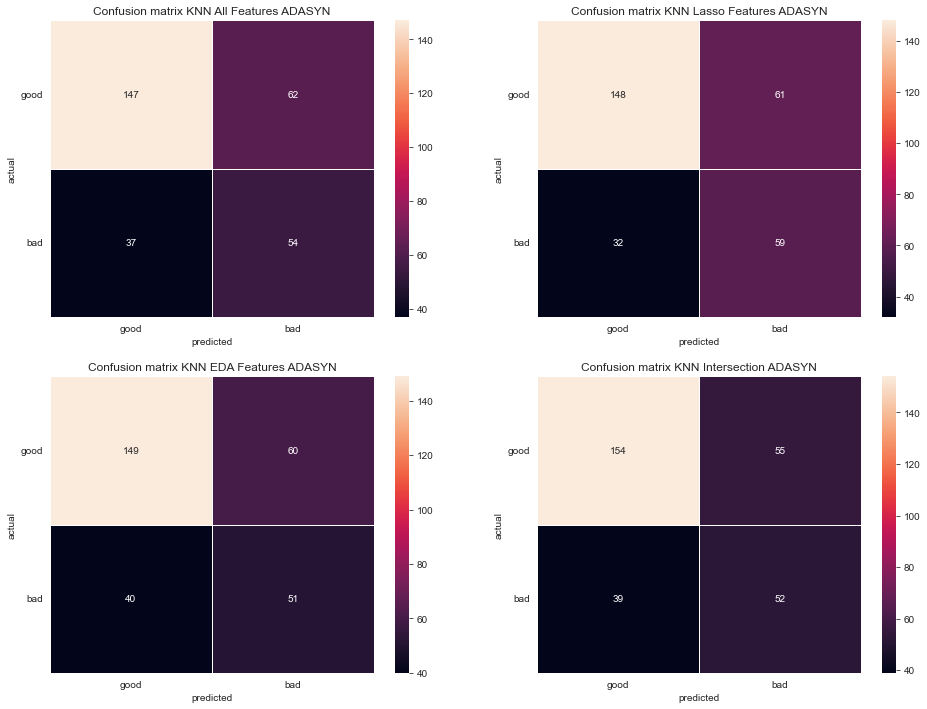

In [167]:
conf_matrix_plot_list([conf_matrix_knn_ada,conf_matrix_knn_Lasso_ada, conf_matrix_knn_Chosen_ada,conf_matrix_knn_Inter_ada],["KNN All Features ADASYN", "KNN Lasso Features ADASYN", "KNN EDA Features ADASYN", "KNN Intersection ADASYN"])

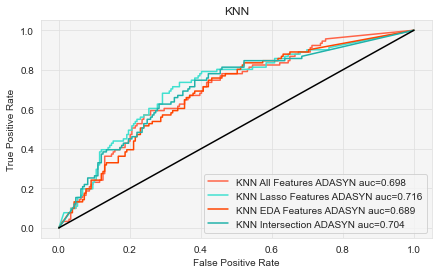

In [168]:
labels = ["KNN All Features ADASYN", "KNN Lasso Features ADASYN", "KNN EDA Features ADASYN", "KNN Intersection ADASYN"]
rocs = [roc_knn_ada, roc_knn_Lasso_ada, roc_knn_Chosen_ada, roc_knn_Inter_ada]
aucs = [roc_auc_knn_ada,roc_auc_knn_Lasso_ada, roc_auc_knn_Chosen_ada, roc_auc_knn_Inter_ada]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN")
plt.legend(loc=4)
plt.show()

# Decision Trees 


In case of decision trees I have used a built in method 'feature_importances_'. The scores are calculated on the weighted Gini indices.

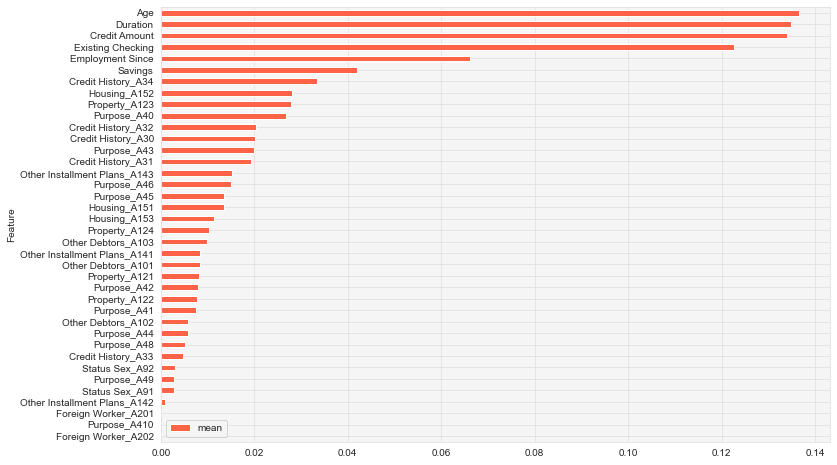

In [169]:
list_results = []
for i in range(10):
    model = DecisionTreeClassifier()
    model.fit(X_train,y_train)
    feat_importances_Decision_Trees = pd.DataFrame({'Importance': model.feature_importances_})
    list_results.append(feat_importances_Decision_Trees)

df_feat_importance = pd.concat(list_results, axis=1)
df_feat_importance['mean'] = df_feat_importance.mean(axis=1)
df_feat_importance = pd.concat([pd.DataFrame({'Feature': Predictors}), df_feat_importance], axis = 1)
df_feat_importance = df_feat_importance[['Feature', 'mean']]
feat_importances_Decision_Trees = df_feat_importance.sort_values(by="mean", ascending = True)
feat_importances_Decision_Trees
feat_importances_Decision_Trees.plot(x='Feature', y='mean', kind='barh', figsize=(12, 8))
plt.show()

In [170]:
# top 5 features
print("Sum of mean importance for top 5 features: ",sum(feat_importances_Decision_Trees.sort_values(by = 'mean', ascending=False).head(5)['mean']))
DT_top5 = list(feat_importances_Decision_Trees.sort_values(by = 'mean', ascending=False).head(5)['Feature'])

Sum of mean importance for top 5 features:  0.5940565195949341


In [171]:
# top 7  features
print("Sum of mean importance for top 7 features: ",sum(feat_importances_Decision_Trees.sort_values(by = 'mean', ascending=False).head(7)['mean']))
DT_top7 = list(feat_importances_Decision_Trees.sort_values(by = 'mean', ascending=False).head(7)['Feature'])

Sum of mean importance for top 7 features:  0.6692565370329148


In [172]:
# top 15 features
print("Sum of mean importance for top 15 features: ", sum(feat_importances_Decision_Trees.sort_values(by = 'mean', ascending=False).head(15)['mean']))
DT_top15 = list(feat_importances_Decision_Trees.sort_values(by = 'mean', ascending=False).head(15)['Feature'])

Sum of mean importance for top 15 features:  0.847130526312052


In [173]:
# top 5 feature subset
X_top5_DT = df_comb[DT_top5].values
X_train_top5_DT, X_test_top5_DT, y_train_top5_DT, y_test_top5_DT = train_test_split(X_top5_DT , y, test_size=0.3, random_state=42)
X_train_top5_DT = PredictorScaler.fit_transform(X_train_top5_DT)
X_test_top5_DT = PredictorScaler.transform(X_test_top5_DT)

# with ADASYN
X_train_top5_DT_ada, y_train_top5_DT_ada = ada.fit_resample(X_train_top5_DT,y_train_top5_DT)

# top 7 features subset 
X_top7_DT = df_comb[DT_top7].values
X_train_top7_DT, X_test_top7_DT, y_train_top7_DT, y_test_top7_DT = train_test_split(X_top7_DT , y, test_size=0.3, random_state=42)
X_train_top7_DT = PredictorScaler.fit_transform(X_train_top7_DT)
X_test_top7_DT = PredictorScaler.transform(X_test_top7_DT)

# with ADASYN
X_train_top7_DT_ada, y_train_top7_DT_ada = ada.fit_resample(X_train_top7_DT,y_train_top7_DT)

# top 15 features subset
X_top15_DT = df_comb[DT_top15].values
X_train_top15_DT, X_test_top15_DT, y_train_top15_DT, y_test_top15_DT = train_test_split(X_top15_DT , y, test_size=0.3, random_state=42)
X_train_top15_DT = PredictorScaler.fit_transform(X_train_top15_DT)
X_test_top15_DT = PredictorScaler.transform(X_test_top15_DT)

# with ADASYN
X_train_top15_DT_ada, y_train_top15_DT_ada = ada.fit_resample(X_train_top15_DT,y_train_top15_DT)

In [174]:
params = {'criterion' : ['gini', 'entropy'],
              'max_depth' : range(1,10),
              'min_samples_split' : range(2,10),
              'min_samples_leaf' : range(1,5)}

df_full_DT_top5, conf_matrix_DT_top5, roc_DT_top5, roc_auc_DT_top5 = model_results(X_train_top5_DT, y_train_top5_DT, X_test_top5_DT, y_test_top5_DT, "DT top5 Features", DecisionTreeClassifier, params, proba=True)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 4}


In [175]:
df_full_DT_top7, conf_matrix_DT_top7, roc_DT_top7, roc_auc_DT_top7 = model_results(X_train_top7_DT, y_train_top7_DT, X_test_top7_DT, y_test_top7_DT, "DT top7 Features", DecisionTreeClassifier, params, proba=True)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}


In [176]:
df_full_DT_top15, conf_matrix_DT_top15, roc_DT_top15, roc_auc_DT_top15 = model_results(X_train_top15_DT, y_train_top15_DT, X_test_top15_DT, y_test_top15_DT, "DT top15 Features", DecisionTreeClassifier, params, proba=True)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 9}


In [177]:
df_full_DT, conf_matrix_DT, roc_DT, roc_auc_DT = model_results(X_train, y_train, X_test, y_test, "DT All Features", DecisionTreeClassifier, params, proba=True)

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 9}


In [178]:
DT_summary = pd.concat([df_full_DT, df_full_DT_top5, df_full_DT_top7, df_full_DT_top15 ], axis = 0)
DT_summary

,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,DT All Features,"{'criterion': 'gini', 'max_depth': 7, 'min_sam...",0.735714,0.366197,0.313253,0.700000,0.880383,0.285714,350
0,DT top5 Features,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.732857,0.427673,0.393519,0.696667,0.837321,0.373626,319
0,DT top7 Features,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.732857,0.423077,0.384615,0.700000,0.846890,0.362637,322
0,DT top15 Features,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",0.737143,0.447368,0.400000,0.720000,0.870813,0.373626,312


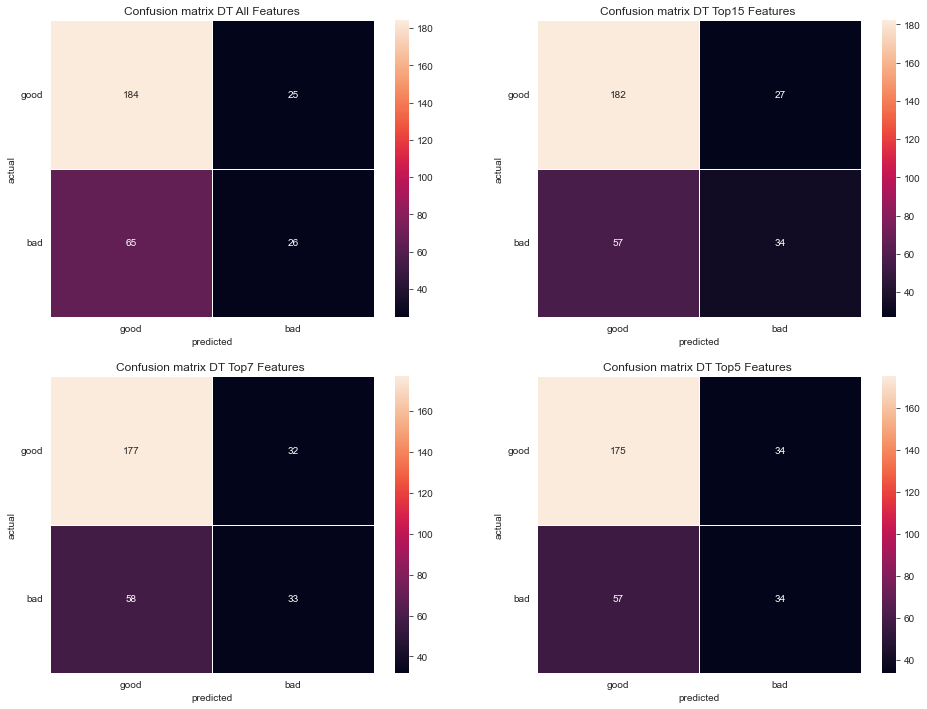

In [179]:
conf_matrix_plot_list([conf_matrix_DT,conf_matrix_DT_top15, conf_matrix_DT_top7,conf_matrix_DT_top5],["DT All Features", "DT Top15 Features ", "DT Top7 Features ", "DT Top5 Features "])

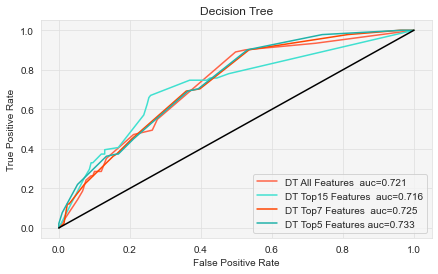

In [180]:
labels = ["DT All Features ", "DT Top15 Features ", "DT Top7 Features ", "DT Top5 Features"]
rocs = [roc_DT, roc_DT_top15, roc_DT_top7, roc_DT_top5]
aucs = [roc_auc_DT,roc_auc_DT_top15, roc_auc_DT_top7, roc_auc_DT_top5]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree")
plt.legend(loc=4)
plt.show()

### Decision Tree with ADASYN

In [181]:
df_full_DT_top5_ada, conf_matrix_DT_top5_ada, roc_DT_top5_ada, roc_auc_DT_top5_ada = model_results(X_train_top5_DT_ada, y_train_top5_DT_ada, X_test_top5_DT, y_test_top5_DT, "DT top5 Features ADASYN", DecisionTreeClassifier, params, proba=True)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 3}


In [182]:
df_full_DT_top7_ada, conf_matrix_DT_top7_ada, roc_DT_top7_ada, roc_auc_DT_top7_ada = model_results(X_train_top7_DT_ada, y_train_top7_DT_ada, X_test_top7_DT, y_test_top7_DT, "DT top7 Features ADASYN", DecisionTreeClassifier, params, proba=True)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 6}


In [183]:
df_full_DT_top15_ada, conf_matrix_DT_top15_ada, roc_DT_top15_ada, roc_auc_DT_top15_ada = model_results(X_train_top15_DT_ada, y_train_top15_DT_ada, X_test_top15_DT, y_test_top15_DT, "DT top15 Features ADASYN", DecisionTreeClassifier, params, proba=True)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4}


In [184]:
df_full_DT_ada, conf_matrix_DT_ada, roc_DT_ada, roc_auc_DT_ada = model_results(X_train_ada, y_train_ada, X_test, y_test, "DT All Features ADASYN", DecisionTreeClassifier, params, proba=True)

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 3}


In [185]:
DT_summary_ada = pd.concat([df_full_DT_ada, df_full_DT_top5_ada, df_full_DT_top7_ada, df_full_DT_top15_ada ], axis = 0)
DT_summary_ada

,model_name,parameters,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,DT All Features ADASYN,"{'criterion': 'gini', 'max_depth': 7, 'min_sam...",0.780536,0.569948,0.590129,0.723333,0.775120,0.604396,227
0,DT top5 Features ADASYN,"{'criterion': 'entropy', 'max_depth': 8, 'min_...",0.701075,0.527778,0.582822,0.660000,0.674641,0.626374,238
0,DT top7 Features ADASYN,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",0.742122,0.562500,0.633803,0.673333,0.665072,0.692308,210
0,DT top15 Features ADASYN,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.779728,0.548387,0.555556,0.720000,0.789474,0.560440,244


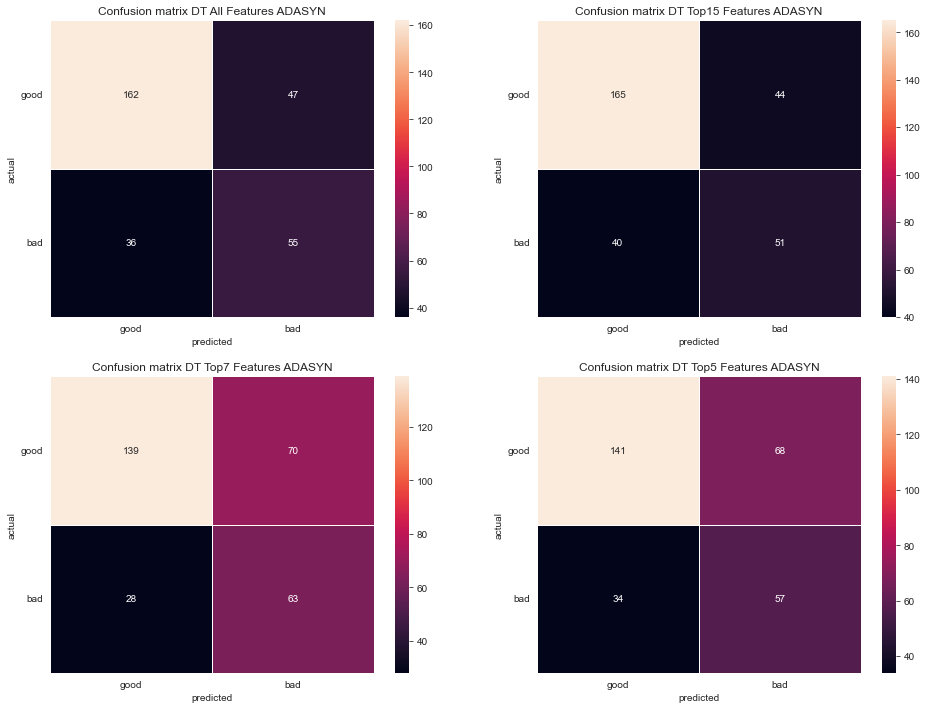

In [186]:
conf_matrix_plot_list([conf_matrix_DT_ada,conf_matrix_DT_top15_ada, conf_matrix_DT_top7_ada,conf_matrix_DT_top5_ada],["DT All Features ADASYN", "DT Top15 Features ADASYN", "DT Top7 Features ADASYN", "DT Top5 Features ADASYN"])

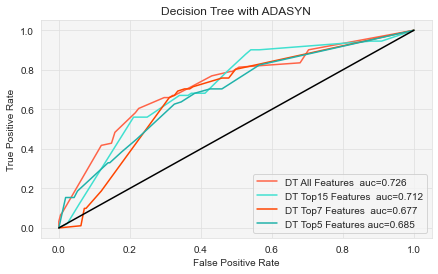

In [187]:
labels = ["DT All Features ", "DT Top15 Features ", "DT Top7 Features ", "DT Top5 Features"]
rocs = [roc_DT_ada, roc_DT_top15_ada, roc_DT_top7_ada, roc_DT_top5_ada]
aucs = [roc_auc_DT_ada,roc_auc_DT_top15_ada, roc_auc_DT_top7_ada, roc_auc_DT_top5_ada]


for roc, roc_auc, label in zip(rocs, aucs, labels):
    plt.plot(roc[0],roc[1],label=str(label)+" auc="+str(round(roc_auc,3)))
plt.plot([0,1], [0,1], color = "black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree with ADASYN")
plt.legend(loc=4)
plt.show()

## Visualization of Decision Tree Top 5 features

In [188]:
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

In [189]:
# top5 features

top5_param = {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
dot_data = StringIO()
dt = DecisionTreeClassifier(**top5_param,random_state=43)  
dt.fit(X_train_top5_DT, y_train_top5_DT)


figure(figsize=(30, 25), dpi=80)
tree.plot_tree(dt, feature_names= DT_top5,  
                   class_names=["Good", "Bad"],
                   filled=True)



NameError: name 'figure' is not defined

## Results Summary

In [ ]:
df_results = pd.concat([LG_summary, LG_summary_ada, KNN_summary, KNN_summary_ada, DT_summary, DT_summary_ada ], axis = 0).sort_values(by= "cost").drop(columns=['parameters'])

In [ ]:
df_results

,model_name,training_score (acc),f1_test,f2_test,accuracy_test,specificity,sensitivity,cost
0,DT top7 Features ADASYN,0.731403,0.580357,0.653924,0.686667,0.674641,0.714286,198
0,DT All Features ADASYN,0.783553,0.583333,0.644172,0.700000,0.703349,0.692308,202
0,DT top15 Features ADASYN,0.742745,0.536170,0.620079,0.636667,0.612440,0.692308,221
0,KNN Lasso Features ADASYN,0.820937,0.559242,0.609504,0.690000,0.708134,0.648352,221
0,Logistic Regression All Features ADASYN,0.690676,0.525822,0.576132,0.663333,0.684211,0.615385,241
0,Logistic Regression Top7 ADASYN,0.666229,0.514019,0.564682,0.653333,0.674641,0.604396,248
0,Logistic Regression Top21 ADASYN,0.696489,0.522167,0.556723,0.676667,0.717703,0.582418,249
0,DT top5 Features ADASYN,0.701075,0.517073,0.554393,0.670000,0.708134,0.582418,251
0,KNN Intersection Features ADASYN,0.763441,0.517073,0.554393,0.670000,0.708134,0.582418,251
0,Logistic Regression Top14 ADASYN,0.691311,0.520000,0.549683,0.680000,0.727273,0.571429,252


<Axes: ylabel='F1 Score'>

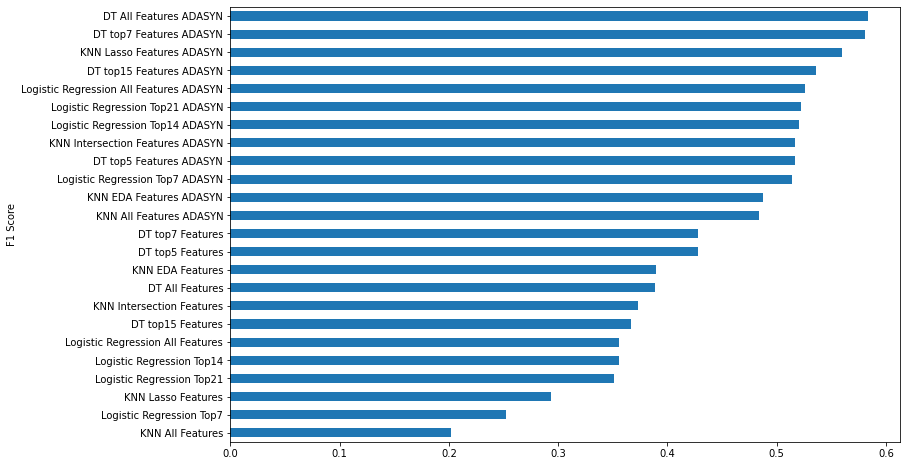

In [ ]:
df_groups_f1 = df_results[['model_name', 'f1_test']].groupby(['model_name'])['f1_test'].sum().sort_values()
df_groups_f1.plot(kind='barh',
               ylabel='F1 Score', figsize=(12, 8))

<Axes: >

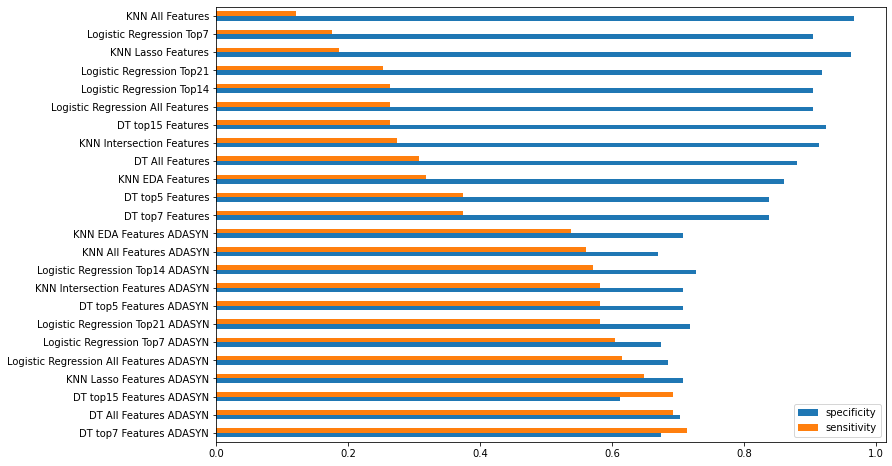

In [ ]:
df_groups_s = df_results[['model_name', 'specificity', 'sensitivity']].groupby(['model_name']).sum().sort_values(by = "sensitivity", ascending = False)#['f1_test'].sum().sort_values()
df_groups_s
df_results.plot(x="model_name", y=["specificity", "sensitivity"], ylabel = "" ,kind="barh", figsize=(12, 8))

<Axes: xlabel='Accuracy', ylabel='model_name'>

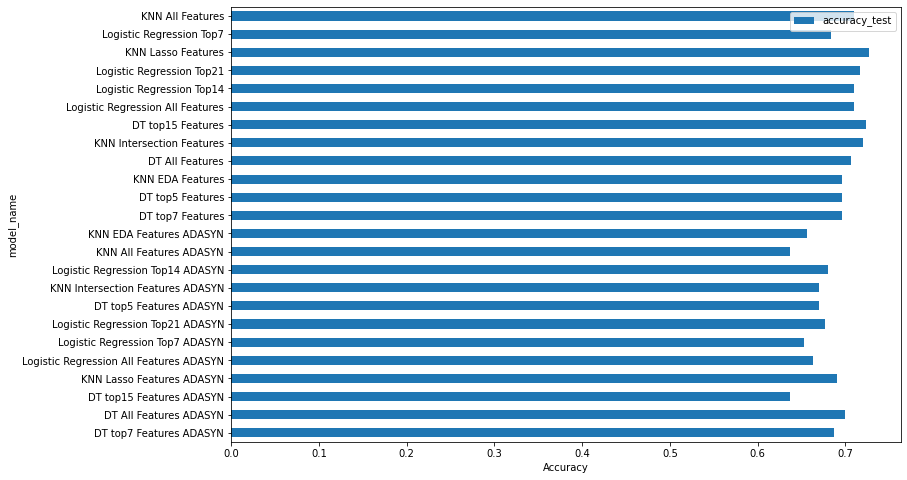

In [ ]:
df_results.plot(x="model_name", y=["accuracy_test"], kind="barh", xlabel = "Accuracy", figsize=(12, 8))

<Axes: >

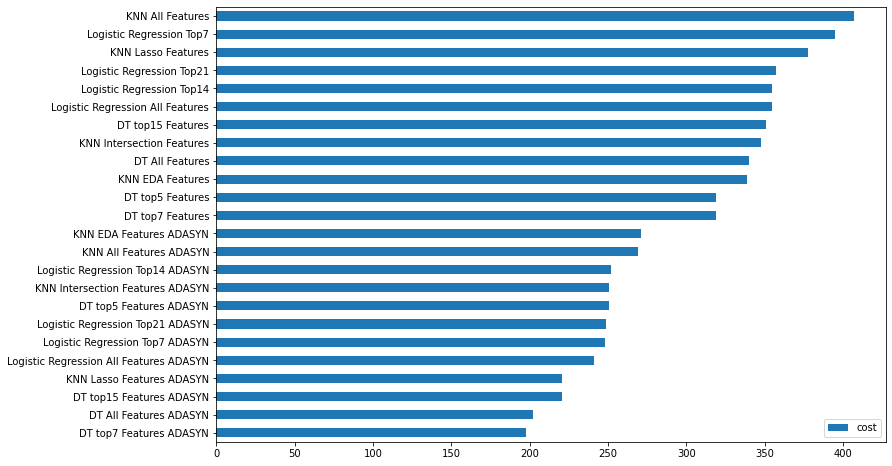

In [ ]:
df_results.plot(x="model_name", y=["cost"], ylabel = "" ,kind="barh", figsize=(12, 8))